In [1]:
from pylab import *
import matplotlib as mpl
from craft import calc11
import numpy as np
from scipy import constants
from craft import uvfits
from craft.craco_plan import PipelinePlan, calc_overlap_channels, FdmtRun, FdmtPlan
from craft.craco import BaselineCell
from craft.fdmt_plan import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# these files exist on keiths laptop

fin = 'output_beam00.uvfits' # this is only 4 seconds of data
fin = 'b00.uvfits'
fin = '/data/seren-07/big/craco/SB052175/scans/00/20230827081815/newplan/b16.uvfits'

In [3]:
f = uvfits.open(fin)

In [4]:
f.nblocks


257

In [5]:
plan = PipelinePlan(f, '--ndm 40')

parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.8142912854112, -59.76660370238069, 2000.0, 205.8142912854112, -59.76660370238069, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 253)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 252)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:146: UserWarni

In [6]:
plan.fdmt_plan

FdmtPlan ncell=1662 zero cell=(213, 4) nruns=274

In [7]:
plan.fdmt_plan.nruns

274

plan.fdmt_plan.nuvtotal

In [8]:
print(f'There are {plan.nbl} baselines and {len(plan.uvcells)} UV cells but after planning we got {plan.fdmt_plan.nuvtotal} cells - which basically sux')

There are 190 baselines and 1662 UV cells but after planning we got 2192 cells - which basically sux


In [9]:
plan.uvcells[0]

Cell blid=1029.0 chan=0-119 freq=887.99-1006.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1)

In [10]:
f2 = uvfits.open(fin, skip_blocks=256)
plan2 = PipelinePlan(f2, '--ndm 40')

parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.8142912854112, -59.76660370238069, 2000.0, 205.8142912854112, -59.76660370238069, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 253)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 252)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:146: UserWarni

In [11]:
(f2.tstart - f.tstart).value*86400

28.311534225940704

In [12]:
def printstats(plan):
    print(f'At {plan.tstart.iso} There are {plan.nbl} baselines and {len(plan.uvcells)} UV cells. After planning we got {plan.fdmt_plan.nruns} runs with {plan.fdmt_plan.nuvtotal} nuvtotal cells up by {plan.fdmt_plan.nuvtotal/len(plan.uvcells)}')
printstats(plan)
printstats(plan2)

At 2023-08-27 08:19:17.758 There are 190 baselines and 1662 UV cells. After planning we got 274 runs with 2192 nuvtotal cells up by 1.3188929001203369
At 2023-08-27 08:19:46.070 There are 190 baselines and 1639 UV cells. After planning we got 273 runs with 2184 nuvtotal cells up by 1.3325198291641245


In [13]:
plan.uvcells[0]

Cell blid=1029.0 chan=0-119 freq=887.99-1006.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1)

In [14]:
plan.uvcells[1]

Cell blid=2571.0 chan=0-21 freq=887.99-908.99 uvpix=(27, 1) upper_idx=282 uvpix_upper=(27, 1)

In [15]:
blids = sorted(plan.baselines.keys())

In [16]:
def printcell(cells, icell):
    if icell >= len(cells):
        s = 'X\t\t\t'
    else:
        c = cells[icell]
        s = f'uv={c.uvpix} chan(n={c.nchan})={c.chan_start}-{c.chan_end}'
    return s



nequal = 0
nreduce = 0
nincrease = 0
for blid in blids:
    p1cells = find_cells(plan.uvcells, blid)
    p2cells = find_cells(plan2.uvcells, blid) 
    
    n1 = len(p1cells)
    n2 = len(p2cells)
    if n2 > n1:
        nincrease += 1
    elif n2 < n1:
        nreduce += 1
    else:
        nequal += 1
    
    
    print(f'Baseline {blid}: ncells {len(p1cells)}->{len(p2cells)}')
    if len(p1cells) < len(p2cells):
        #print(f'Baseline ID {blid} from {plan.tstart.iso} to {plan2.tstart.iso}')
        for icell in range(max(len(p1cells), len(p2cells))):
            newcell = p2cells[icell]
            if len(p1cells) == 0:
                print('This baseline isnt in the previous plan. Grrr')
            else:
                best = get_cell_with_highest_overlap(newcell, p1cells)
                overlap = cell_channel_overlap(newcell, best)
                print(f'i=[{icell}]', printcell(p1cells, icell), '\t', printcell(p2cells, icell), 'best=',best, 'overlap=', overlap)
                        
            
        
print(f'nequal={nequal} nincrease={nincrease} nreduce={nreduce}')            

Baseline 258.0: ncells 1->1
Baseline 260.0: ncells 0->0
Baseline 261.0: ncells 3->3
Baseline 262.0: ncells 3->3
Baseline 263.0: ncells 5->5
Baseline 264.0: ncells 5->5
Baseline 265.0: ncells 5->5
Baseline 266.0: ncells 6->6
Baseline 267.0: ncells 7->7
Baseline 268.0: ncells 8->8
Baseline 269.0: ncells 11->11
Baseline 270.0: ncells 6->6
Baseline 272.0: ncells 13->12
Baseline 274.0: ncells 7->7
Baseline 275.0: ncells 8->7
Baseline 276.0: ncells 9->8
Baseline 277.0: ncells 10->11
i=[0] uv=(52, 238) chan(n=11)=0-10 	 uv=(52, 239) chan(n=5)=0-4 best= Cell blid=277.0 chan=0-10 freq=887.99-897.99 uvpix=(52, 238) upper_idx=4641 uvpix_upper=(204, 18) overlap= 5
i=[1] uv=(53, 238) chan(n=18)=11-28 	 uv=(52, 238) chan(n=6)=5-10 best= Cell blid=277.0 chan=0-10 freq=887.99-897.99 uvpix=(52, 238) upper_idx=4641 uvpix_upper=(204, 18) overlap= 6
i=[2] uv=(54, 238) chan(n=17)=29-45 	 uv=(53, 238) chan(n=17)=11-27 best= Cell blid=277.0 chan=11-28 freq=898.99-915.99 uvpix=(53, 238) upper_idx=4640 uvpix_u

i=[8] uv=(196, 215) chan(n=6)=82-87 	 uv=(197, 215) chan(n=16)=66-81 best= Cell blid=1552.0 chan=66-81 freq=953.99-968.99 uvpix=(197, 215) upper_idx=9694 uvpix_upper=(59, 41) overlap= 16
i=[9] uv=(196, 214) chan(n=10)=88-97 	 uv=(196, 215) chan(n=3)=82-84 best= Cell blid=1552.0 chan=82-87 freq=969.99-974.99 uvpix=(196, 215) upper_idx=9695 uvpix_upper=(60, 41) overlap= 3
i=[10] uv=(195, 214) chan(n=13)=98-110 	 uv=(196, 214) chan(n=14)=85-98 best= Cell blid=1552.0 chan=88-97 freq=975.99-984.99 uvpix=(196, 214) upper_idx=9909 uvpix_upper=(60, 42) overlap= 10
i=[11] uv=(195, 213) chan(n=4)=111-114 	 uv=(195, 214) chan(n=9)=99-107 best= Cell blid=1552.0 chan=98-110 freq=985.99-997.99 uvpix=(195, 214) upper_idx=9910 uvpix_upper=(61, 42) overlap= 9
i=[12] uv=(194, 213) chan(n=5)=115-119 	 uv=(195, 213) chan(n=7)=108-114 best= Cell blid=1552.0 chan=111-114 freq=998.99-1001.99 uvpix=(195, 213) upper_idx=10123 uvpix_upper=(61, 43) overlap= 4
i=[13] X			 	 uv=(194, 213) chan(n=5)=115-119 best= C

i=[4] uv=(27, 241) chan(n=31)=89-119 	 uv=(27, 242) chan(n=6)=89-94 best= Cell blid=2579.0 chan=89-119 freq=976.99-1006.99 uvpix=(27, 241) upper_idx=3949 uvpix_upper=(229, 15) overlap= 6
i=[5] X			 	 uv=(27, 241) chan(n=25)=95-119 best= Cell blid=2579.0 chan=89-119 freq=976.99-1006.99 uvpix=(27, 241) upper_idx=3949 uvpix_upper=(229, 15) overlap= 25
Baseline 2580.0: ncells 8->8
Baseline 2581.0: ncells 11->10
Baseline 2582.0: ncells 12->11
Baseline 2583.0: ncells 13->13
Baseline 2828.0: ncells 3->3
Baseline 2829.0: ncells 11->11
Baseline 2830.0: ncells 13->14
i=[0] uv=(230, 70) chan(n=7)=0-6 	 uv=(230, 70) chan(n=5)=0-4 best= Cell blid=2830.0 chan=0-6 freq=887.99-893.99 uvpix=(230, 70) upper_idx=15665 uvpix_upper=(230, 70) overlap= 5
i=[1] uv=(229, 70) chan(n=4)=7-10 	 uv=(229, 70) chan(n=8)=5-12 best= Cell blid=2830.0 chan=7-10 freq=894.99-897.99 uvpix=(229, 70) upper_idx=15664 uvpix_upper=(229, 70) overlap= 4
i=[2] uv=(229, 71) chan(n=13)=11-23 	 uv=(229, 71) chan(n=13)=13-25 best= Cel

i=[7] uv=(42, 113) chan(n=8)=42-49 	 uv=(42, 112) chan(n=1)=41-41 best= Cell blid=4119.0 chan=40-41 freq=927.99-928.99 uvpix=(42, 112) upper_idx=26638 uvpix_upper=(214, 144) overlap= 1
i=[8] uv=(42, 114) chan(n=8)=50-57 	 uv=(42, 113) chan(n=8)=42-49 best= Cell blid=4119.0 chan=42-49 freq=929.99-936.99 uvpix=(42, 113) upper_idx=26526 uvpix_upper=(214, 143) overlap= 8
i=[9] uv=(42, 115) chan(n=4)=58-61 	 uv=(42, 114) chan(n=8)=50-57 best= Cell blid=4119.0 chan=50-57 freq=937.99-944.99 uvpix=(42, 114) upper_idx=26413 uvpix_upper=(214, 142) overlap= 8
i=[10] uv=(43, 115) chan(n=5)=62-66 	 uv=(42, 115) chan(n=6)=58-63 best= Cell blid=4119.0 chan=58-61 freq=945.99-948.99 uvpix=(42, 115) upper_idx=26299 uvpix_upper=(214, 141) overlap= 4
i=[11] uv=(43, 116) chan(n=8)=67-74 	 uv=(43, 115) chan(n=3)=64-66 best= Cell blid=4119.0 chan=62-66 freq=949.99-953.99 uvpix=(43, 115) upper_idx=26298 uvpix_upper=(213, 141) overlap= 3
i=[12] uv=(43, 117) chan(n=8)=75-82 	 uv=(43, 116) chan(n=8)=67-74 best= 

In [17]:
cell = plan.uvcells[100]
print(cell)
chan_positions = np.arange(0,32*12,32)

print(chan_positions)
chan = chan_with_best_overlap(cell, chan_positions, chan_width=32)


Cell blid=1545.0 chan=62-74 freq=949.99-961.99 uvpix=(226, 249) upper_idx=1794 uvpix_upper=(30, 7)
[  0  32  64  96 128 160 192 224 256 288 320 352]


In [18]:
run_cells = fixed_algorithm(plan.uvcells, chan_positions, chan_width=32)
runs = [FdmtRun.from_cells(cells, plan.fdmt_plan, chan_start) for (chan_start, cells) in run_cells]
runs

[ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=252,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=221,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=206,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=191,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=177,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=163,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=155,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=149,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=144,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=140,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=132,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=128,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=128,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=120,
 ncells=8 fch1=887990740.

# Making a new plan from an old one

Baselines indexes don't change. FDMT chan_positions and chan_width don't change. UVWs and cells change. A given input uvcell will have a 1-many relationship to planned UVcells due to NCIN limit (i.e. cells with > 32 channels will be split).

In [19]:
initial_runs = [FdmtRun.from_cells(cells, plan.fdmt_plan, chan_start) for (chan_start, cells) in run_cells]
run_cells2 = fixed_algorithm(plan2.uvcells, chan_positions, chan_width=32)
runs2 = [FdmtRun.from_cells(cells, plan2.fdmt_plan, chan_start) for (chan_start, cells) in run_cells2]


In [20]:
plan.fdmt_plan.runs[0]

ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256

In [21]:
initial_runs[0]

ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256

In [22]:
import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)

container1 = FdmtPlanContainer(plan.fdmt_plan, plan.fdmt_plan.runs, None)
container2 = FdmtPlanContainer(plan2.fdmt_plan, runs2, container1)

It's assigning new runs to old runs and then gets to 96-105. This started out as 96-119 and then got split into 96-105 and 106-119. 96-105 has 10 channels and it tries to find somethign to overlap. 106-119 has already eaten that cell (14 channels), so there's noethign left for it. We should leave it and add it as a new thing. But we can keep doing other ones as there's one more channel to go

In [23]:
container2.runs[0]

ncells=0 fch1=887990740.7407408 chan_start=0 total_overlap=0

In [24]:
container2.nchan

0

In [25]:
migrate_plan(container1, container2)

INFO:craft.fdmt_plan:Migrated plan from FdmtPlanContainer nruns=274 nc=21935 overlap=0=0.0% to FdmtPlanContainer nruns=291 nc=21900 overlap=19733=90.1%


FdmtPlanContainer nruns=291 nc=21900 overlap=19733=90.1%

In [26]:
container1

FdmtPlanContainer nruns=274 nc=21935 overlap=0=0.0%

In [27]:
container1.nchan_array

array([[32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 30., 30.],
       [29., 29., 28., ..., 27., 27., 27.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

<IPython.core.display.Javascript object>


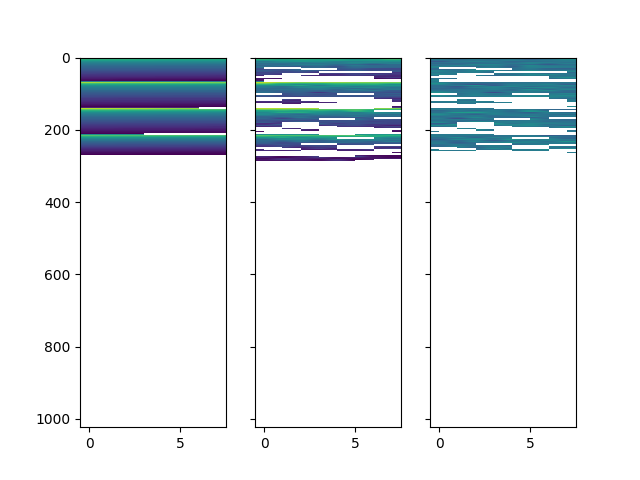

In [28]:
fig,ax = subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(container1.nchan_array, aspect='auto')
ax[1].imshow(container2.nchan_array, aspect='auto')
ax[2].imshow(container2.nchan_array - container1.nchan_array, aspect='auto')

<IPython.core.display.Javascript object>


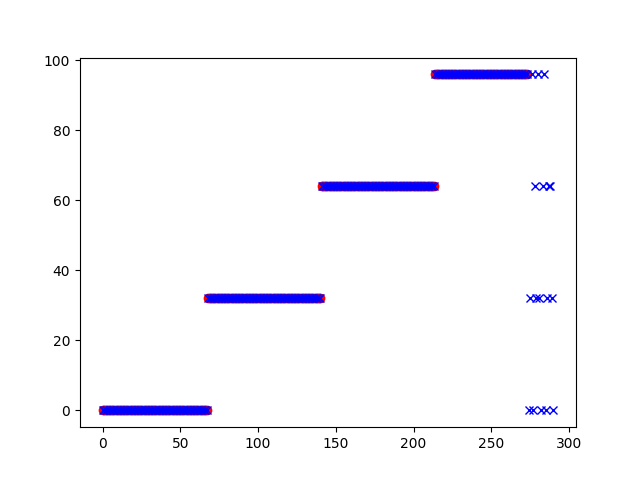

In [29]:
figure()
plot(container1.start_chan_array, 'ro')
plot(container2.start_chan_array,'bx')

In [30]:
container2.nchan
print(container2.nchan == sum(c.nchan for c in plan2.uvcells))

True


/data/seren-01/fast/ban115/build/venv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [31]:
print(container1.nchan)
print(container1.nchan == sum(c.nchan for c in plan.uvcells))

21935
True


/data/seren-01/fast/ban115/build/venv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [32]:
blid = 268.0
cells1 = container1.uvcells_of(blid)
cells2 = container2.uvcells_of(blid)

In [33]:
container2.plan.pipeline_plan.nbl

190

In [34]:
container2.total_overlap


19733

In [35]:
container2.nchan

21900

In [36]:
cells2

[Cell blid=268.0 chan=0-0 freq=887.99-887.99 uvpix=(30, 238) upper_idx=4663 uvpix_upper=(226, 18),
 Cell blid=268.0 chan=1-30 freq=888.99-917.99 uvpix=(31, 238) upper_idx=4662 uvpix_upper=(225, 18),
 Cell blid=268.0 chan=31-31 freq=918.99-918.99 uvpix=(32, 238) upper_idx=4661 uvpix_upper=(224, 18),
 Cell blid=268.0 chan=32-59 freq=919.99-946.99 uvpix=(32, 237) upper_idx=4898 uvpix_upper=(224, 19),
 Cell blid=268.0 chan=60-63 freq=947.99-950.99 uvpix=(33, 237) upper_idx=4897 uvpix_upper=(223, 19),
 Cell blid=268.0 chan=64-81 freq=951.99-968.99 uvpix=(33, 237) upper_idx=4897 uvpix_upper=(223, 19),
 Cell blid=268.0 chan=82-88 freq=969.99-975.99 uvpix=(33, 236) upper_idx=5133 uvpix_upper=(223, 20),
 Cell blid=268.0 chan=89-95 freq=976.99-982.99 uvpix=(34, 236) upper_idx=5132 uvpix_upper=(222, 20),
 Cell blid=268.0 chan=96-117 freq=983.99-1004.99 uvpix=(34, 236) upper_idx=5132 uvpix_upper=(222, 20),
 Cell blid=268.0 chan=118-119 freq=1005.99-1006.99 uvpix=(35, 236) upper_idx=5131 uvpix_uppe

OK - I'm not really thinking clearly here - I think I need to come back to this when I'm not sick. It's fine, it just takes a bit more wrangling to celar up the data structure.

In [37]:
plan1 = PipelinePlan(f, '--ndm 40')
plan2 = PipelinePlan(f2, '--ndm 40', prev_plan=plan1)

INFO:craft.craco_plan:Unknown beamid
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', calibration=None, cell=None, fdmt_scale=1.0, fft_scale=10.0, flag_ants=None, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=40, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, target_input_rms=512, threshold=3, uv='uv_data', verbose=False) prev plan:None


parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.8142912854112, -59.76660370238069, 2000.0, 205.8142912854112, -59.76660370238069, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
INFO:craft.uvfits:Got radec=(205.8142912854112 deg/-59.76660370238069 deg) from source table for VAST_1404-62
INFO:craft.craco_plan:Nbl=190 Fch1=887990740.740741 foff=1000000.000000 nchan=120 lambdamin=0.297917 uvmax=(4886.256183011836, 3187.6094461132966) max baseline=(1.4557004305970622, 0.9496441180090187) resolution=[42.21326073 64.70830562]arcsec uvcell=[20.10155273 30.81347887] arcsec uvcell= (40.08257025126896, 26.148358737648138) lambda FoV=[1.42944375 2.19118072] deg oversampled=(2.1, 2.1) wcs=WCS Keywords

Number of WCS axes: 2

INFO:craft.craco_plan:Unknown beamid
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', calibration=None, cell=None, fdmt_scale=1.0, fft_scale=10.0, flag_ants=None, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=40, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, target_input_rms=512, threshold=3, uv='uv_data', verbose=False) prev plan:<craft.craco_plan.PipelinePlan object at 0x7efdf91f1e48>


parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.8142912854112, -59.76660370238069, 2000.0, 205.8142912854112, -59.76660370238069, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
INFO:craft.uvfits:Got radec=(205.8142912854112 deg/-59.76660370238069 deg) from source table for VAST_1404-62
INFO:craft.craco_plan:Nbl=190 Fch1=887990740.740741 foff=1000000.000000 nchan=120 lambdamin=0.297917 uvmax=(4884.261913662999, 3190.8353084388714) max baseline=(1.455106303183129, 0.9506051583230146) resolution=[42.23049662 64.64288699]arcsec uvcell=[20.1097603  30.78232714] arcsec uvcell= (40.066211010516795, 26.17482088953762) lambda FoV=[1.4300274  2.18896549] deg oversampled=(2.1, 2.1) wcs=WCS Keywords

Number of WCS axes: 2


In [38]:
plan1.fdmt_plan

INFO:craft.fdmt_plan:Started with 1662 cells which would need at least 208 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 274 runs. An increase of 1.317 
INFO:craft.fdmt_plan:Creating FdmtPlan for 1662 cells plan=<craft.craco_plan.PipelinePlan object at 0x7efdf91f1e48> prev_plan=None We have 274 initial runs
INFO:craft.fdmt_plan:Found zero cell among runs: (213, 4)
INFO:craft.fdmt_plan:FDMT zero cell is (213, 4)=1708
INFO:craft.fdmt_plan:FDMT plan has ntotal=2192 of 274 runs with packing efficiency 0.758212. Grid read requires efficiency of > 0.267578 of NUV=8192. History size square=120682752 minimal=6293752 =0 256MB HBM banks
INFO:craft.craco_plan:Saving uvgrid.split shape=(2184, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:craft.craco_plan:Got 1581 unique UV coords. Upper=True
INFO:craft.craco_plan:Need to write 99 groups of 1

FdmtPlan ncell=1662 zero cell=(213, 4) nruns=274

In [39]:
logger.setLevel(logging.DEBUG)
#logger.setLevel(logging.INFO)

plan2.fdmt_plan

INFO:craft.fdmt_plan:Started with 1639 cells which would need at least 205 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 273 runs. An increase of 1.332 
INFO:craft.fdmt_plan:Creating FdmtPlan for 1639 cells plan=<craft.craco_plan.PipelinePlan object at 0x7efdf91f1e10> prev_plan=<craft.craco_plan.PipelinePlan object at 0x7efdf91f1e48> We have 273 initial runs
INFO:craft.fdmt_plan:Migrate plan from FdmtPlan ncell=1662 zero cell=(213, 4) nruns=274 to FdmtPlan ncell=1639 zero cell=None nruns=0 with 273 new runs
DEBUG:craft.fdmt_plan:Added run at 0 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256
DEBUG:craft.fdmt_plan:Added run at 1 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=252
DEBUG:craft.fdmt_plan:Added run at 2 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=221
DEBUG:craft.fdmt_plan:Added run at 3 with chan_start=0 prev=ncells=8 fch1=887990740.740

DEBUG:craft.fdmt_plan:Added run at 63 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 64 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=14
DEBUG:craft.fdmt_plan:Added run at 65 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 66 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 67 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 68 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=256
DEBUG:craft.fdmt_plan:Added run at 69 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=249
DEBUG:craft.fdmt_plan:Added run at 70 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=208
DEBUG:craf

DEBUG:craft.fdmt_plan:Added run at 129 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=24
DEBUG:craft.fdmt_plan:Added run at 130 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=24
DEBUG:craft.fdmt_plan:Added run at 131 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=21
DEBUG:craft.fdmt_plan:Added run at 132 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 133 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 134 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 135 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 136 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_ove

DEBUG:craft.fdmt_plan:Added run at 194 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=40
DEBUG:craft.fdmt_plan:Added run at 195 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=40
DEBUG:craft.fdmt_plan:Added run at 196 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=34
DEBUG:craft.fdmt_plan:Added run at 197 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=32
DEBUG:craft.fdmt_plan:Added run at 198 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=32
DEBUG:craft.fdmt_plan:Added run at 199 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=32
DEBUG:craft.fdmt_plan:Added run at 200 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=30
DEBUG:craft.fdmt_plan:Added run at 201 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_ove

DEBUG:craft.fdmt_plan:Added run at 259 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=27
DEBUG:craft.fdmt_plan:Added run at 260 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=24
DEBUG:craft.fdmt_plan:Added run at 261 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=24
DEBUG:craft.fdmt_plan:Added run at 262 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=21
DEBUG:craft.fdmt_plan:Added run at 263 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 264 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 265 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 266 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_ove

DEBUG:craft.fdmt_plan:Assigning coord=(244, 3) overlap=8 nc=8->8 old=112-119=8 (251, 228) requested=112-119=8 (251, 228)
DEBUG:craft.fdmt_plan:Assigning coord=(61, 0) overlap=3 nc=3->3 old=0-2=3 (251, 232) requested=0-2=3 (251, 232)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=720 overlap=698 next run=275
DEBUG:craft.fdmt_plan:Assigning coord=(73, 3) overlap=18 nc=22->18 old=38-59=22 (233, 25) requested=41-58=18 (233, 25)
DEBUG:craft.fdmt_plan:Assigning coord=(227, 1) overlap=14 nc=14->18 old=100-113=14 (231, 26) requested=99-116=18 (231, 26)
DEBUG:craft.fdmt_plan:Assigning coord=(148, 3) overlap=17 nc=20->17 old=76-95=20 (232, 26) requested=79-95=17 (232, 26)
DEBUG:craft.fdmt_plan:Assigning coord=(7, 1) overlap=16 nc=20->16 old=0-19=20 (234, 24) requested=3-18=16 (234, 24)
DEBUG:craft.fdmt_plan:Assigning coord=(165, 5) overlap=12 nc=12->15 old=64-75=12 (232, 25) r

DEBUG:craft.fdmt_plan:Assigning coord=(139, 1) overlap=1 nc=1->3 old=48-48=1 (243, 217) requested=48-50=3 (243, 217)
DEBUG:craft.fdmt_plan:Assigning coord=(271, 5) overlap=1 nc=1->1 old=96-96=1 (242, 216) requested=96-96=1 (242, 216)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=2057.0 chan=119-119 freq=1006.99-1006.99 uvpix=(241, 215) upper_idx=32061 uvpix_upper=(241, 215)]
DEBUG:craft.fdmt_plan:Plan2 nchan=1320 overlap=1246 next run=275
DEBUG:craft.fdmt_plan:Assigning coord=(14, 5) overlap=15 nc=15->18 old=5-19=15 (44, 43) requested=3-20=18 (44, 43)
DEBUG:craft.fdmt_plan:Assigning coord=(84, 6) overlap=14 nc=14->17 old=47-60=14 (46, 45) requested=45-61=17 (46, 45)
DEBUG:craft.fdmt_plan:Assigning coord=(157, 7) overlap=14 nc=14->16 old=68-81=14 (47, 46) requested=66-81=16 (47, 46)
DEBUG:craft.fdmt_plan:Assigning coord=(237, 0) overlap=10 nc=10->12 old=110-119=10 (49, 48) requested=108-119=1

DEBUG:craft.fdmt_plan:Found spare cell in irun=140 ncells=7 fch1=919990740.7407407 chan_start=32 total_overlap=7 at icell=7
DEBUG:craft.fdmt_plan:Assigning coord=(140, 7) overlap=0 nc=X->7 old=------ (--,--) requested=45-51=7 (215, 18)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=1044.0 chan=32-37 freq=919.99-924.99 uvpix=(41, 239) upper_idx=4414 uvpix_upper=(215, 17), Cell blid=1044.0 chan=91-95 freq=978.99-982.99 uvpix=(43, 237) upper_idx=4887 uvpix_upper=(213, 19)]
DEBUG:craft.fdmt_plan:Plan2 nchan=1920 overlap=1783 next run=275
DEBUG:craft.fdmt_plan:Assigning coord=(69, 1) overlap=32 nc=32->32 old=32-63=32 (14, 3) requested=32-63=32 (14, 3)
DEBUG:craft.fdmt_plan:Assigning coord=(142, 3) overlap=31 nc=31->31 old=64-94=31 (14, 3) requested=64-94=31 (14, 3)
DEBUG:craft.fdmt_plan:Assigning coord=(2, 3) overlap=27 nc=27->27 old=0-26=27 (13, 3) requested=0-26=27 (13, 3)
DEBUG:craft.fdmt_plan:Assigning coord=(216, 6) overlap=24 nc=24->24 old=96-119=24 (15, 3

DEBUG:craft.fdmt_plan:Assigning coord=(35, 2) overlap=9 nc=9->11 old=23-31=9 (202, 15) requested=21-31=11 (202, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(101, 2) overlap=9 nc=9->10 old=55-63=9 (200, 15) requested=54-63=10 (200, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(238, 6) overlap=9 nc=10->9 old=96-105=10 (198, 16) requested=96-104=9 (198, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(183, 6) overlap=7 nc=7->8 old=89-95=7 (198, 16) requested=88-95=8 (198, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(182, 2) overlap=7 nc=8->7 old=64-71=8 (200, 15) requested=64-70=7 (200, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(54, 6) overlap=4 nc=4->4 old=0-3=4 (204, 14) requested=0-3=4 (204, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(118, 0) overlap=4 nc=6->4 old=32-37=6 (202, 15) requested=33-36=4 (202, 15)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=1045.0 chan=32-32 freq=919.99-919.99 uvpix=(54, 242) upper_idx=3681 uvpix_upper=(202, 14)]
DEBUG:craft.fdmt_plan:Found 

DEBUG:craft.fdmt_plan:Assigning coord=(97, 6) overlap=8 nc=10->8 old=54-63=10 (196, 42) requested=56-63=8 (196, 42)
DEBUG:craft.fdmt_plan:Assigning coord=(163, 3) overlap=7 nc=12->7 old=74-85=12 (195, 43) requested=78-84=7 (195, 43)
DEBUG:craft.fdmt_plan:Assigning coord=(47, 5) overlap=6 nc=6->6 old=0-5=6 (200, 39) requested=0-5=6 (200, 39)
DEBUG:craft.fdmt_plan:Assigning coord=(118, 4) overlap=5 nc=6->5 old=32-37=6 (198, 41) requested=33-37=5 (198, 41)
DEBUG:craft.fdmt_plan:Assigning coord=(191, 1) overlap=5 nc=6->5 old=64-69=6 (196, 42) requested=64-68=5 (196, 42)
DEBUG:craft.fdmt_plan:Assigning coord=(249, 3) overlap=5 nc=6->5 old=96-101=6 (194, 44) requested=96-100=5 (194, 43)
DEBUG:craft.fdmt_plan:Assigning coord=(66, 2) overlap=1 nc=1->4 old=6-6=1 (200, 40) requested=6-9=4 (199, 39)
DEBUG:craft.fdmt_plan:Assigning coord=(128, 5) overlap=1 nc=3->3 old=51-53=3 (197, 42) requested=53-55=3 (196, 41)
DEBUG:craft.fdmt_plan:Assigning coord=(263, 7) overlap=2 nc=2->3 old=117-118=2 (192, 

DEBUG:craft.fdmt_plan:Assigning coord=(99, 5) overlap=10 nc=10->13 old=32-41=10 (220, 41) requested=32-44=13 (220, 41)
DEBUG:craft.fdmt_plan:Assigning coord=(27, 5) overlap=10 nc=11->10 old=21-31=11 (220, 41) requested=22-31=10 (220, 41)
DEBUG:craft.fdmt_plan:Assigning coord=(234, 3) overlap=8 nc=11->8 old=109-119=11 (217, 45) requested=112-119=8 (217, 45)
DEBUG:craft.fdmt_plan:Assigning coord=(171, 3) overlap=6 nc=10->6 old=86-95=10 (218, 44) requested=90-95=6 (218, 44)
DEBUG:craft.fdmt_plan:Assigning coord=(180, 1) overlap=4 nc=8->4 old=64-71=8 (219, 43) requested=67-70=4 (219, 43)
DEBUG:craft.fdmt_plan:Assigning coord=(62, 7) overlap=1 nc=2->2 old=19-20=2 (221, 41) requested=20-21=2 (220, 40)
DEBUG:craft.fdmt_plan:Assigning coord=(120, 0) overlap=1 nc=5->1 old=42-46=5 (220, 42) requested=45-45=1 (220, 42)
DEBUG:craft.fdmt_plan:Assigning coord=(266, 3) overlap=1 nc=2->1 old=96-97=2 (218, 44) requested=96-96=1 (218, 44)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [C

DEBUG:craft.fdmt_plan:Assigning coord=(28, 2) overlap=11 nc=11->13 old=0-10=11 (233, 63) requested=0-12=13 (233, 63)
DEBUG:craft.fdmt_plan:Assigning coord=(39, 7) overlap=8 nc=8->12 old=17-24=8 (232, 64) requested=15-26=12 (232, 64)
DEBUG:craft.fdmt_plan:Assigning coord=(85, 2) overlap=12 nc=14->12 old=40-53=14 (232, 66) requested=41-52=12 (232, 66)
DEBUG:craft.fdmt_plan:Assigning coord=(109, 6) overlap=8 nc=8->9 old=32-39=8 (232, 65) requested=32-40=9 (232, 65)
DEBUG:craft.fdmt_plan:Assigning coord=(102, 3) overlap=8 nc=9->8 old=55-63=9 (231, 67) requested=56-63=8 (231, 67)
DEBUG:craft.fdmt_plan:Assigning coord=(163, 6) overlap=8 nc=12->8 old=82-93=12 (231, 69) requested=84-91=8 (231, 69)
DEBUG:craft.fdmt_plan:Assigning coord=(237, 3) overlap=8 nc=10->8 old=110-119=10 (230, 71) requested=112-119=8 (230, 71)
DEBUG:craft.fdmt_plan:Assigning coord=(199, 3) overlap=4 nc=4->6 old=64-67=4 (231, 67) requested=64-69=6 (231, 67)
DEBUG:craft.fdmt_plan:Assigning coord=(44, 4) overlap=5 nc=7->5 o

DEBUG:craft.fdmt_plan:Added run at 277 with chan_start=0 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=277 for Cell blid=3088.0 chan=14-18 freq=901.99-905.99 uvpix=(180, 228) upper_idx=6838 uvpix_upper=(76, 28) at cstart=0
DEBUG:craft.fdmt_plan:Assigning coord=(277, 0) overlap=0 nc=X->5 old=------ (--,--) requested=14-18=5 (76, 28)
DEBUG:craft.fdmt_plan:Found spare cell in irun=276 None at icell=2
DEBUG:craft.fdmt_plan:Assigning coord=(276, 2) overlap=0 nc=X->5 old=------ (--,--) requested=109-113=5 (84, 31)
DEBUG:craft.fdmt_plan:Added run at 278 with chan_start=64 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=278 for Cell blid=3088.0 chan=82-84 freq=969.99-971.99 uvpix=(175, 225) upper_idx=7521 uvpix_upper=(81, 31) at cstart=64
DEBUG:craft.fdmt_plan:Assigning coord=(278, 0) overlap=0 nc=X->3 old=------ (--,--) requested=82-84=3 (81, 31)
DEBUG:craft.fdmt_plan:Added run at 279 with chan_start=32 prev=None
DEBUG:craft.fdmt_plan:No space f

DEBUG:craft.fdmt_plan:Assigning coord=(204, 2) overlap=3 nc=3->3 old=64-66=3 (67, 5) requested=64-66=3 (67, 5)
DEBUG:craft.fdmt_plan:Assigning coord=(210, 4) overlap=1 nc=1->1 old=95-95=1 (70, 5) requested=95-95=1 (70, 5)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=4897 overlap=4374 next run=280
DEBUG:craft.fdmt_plan:Assigning coord=(26, 7) overlap=11 nc=11->11 old=9-19=11 (84, 26) requested=9-19=11 (84, 26)
DEBUG:craft.fdmt_plan:Assigning coord=(94, 0) overlap=11 nc=11->11 old=41-51=11 (87, 27) requested=41-51=11 (87, 27)
DEBUG:craft.fdmt_plan:Assigning coord=(94, 1) overlap=11 nc=11->11 old=52-62=11 (88, 27) requested=52-62=11 (88, 27)
DEBUG:craft.fdmt_plan:Assigning coord=(166, 6) overlap=11 nc=11->11 old=73-83=11 (90, 28) requested=73-83=11 (90, 28)
DEBUG:craft.fdmt_plan:Assigning coord=(166, 7) overlap=11 nc=11->11 old=84-94=11 (91, 28) requested=84-94=11 (91

DEBUG:craft.fdmt_plan:Assigning coord=(179, 4) overlap=5 nc=8->5 old=67-74=8 (116, 32) requested=67-71=5 (116, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(192, 5) overlap=5 nc=5->5 old=91-95=5 (119, 33) requested=91-95=5 (119, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(39, 4) overlap=4 nc=8->4 old=9-16=8 (109, 30) requested=9-12=4 (109, 30)
DEBUG:craft.fdmt_plan:Assigning coord=(259, 0) overlap=4 nc=4->4 old=96-99=4 (119, 33) requested=96-99=4 (119, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(255, 4) overlap=4 nc=4->4 old=116-119=4 (122, 34) requested=116-119=4 (122, 34)
DEBUG:craft.fdmt_plan:Assigning coord=(204, 6) overlap=3 nc=3->3 old=64-66=3 (115, 32) requested=64-66=3 (115, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(135, 1) overlap=2 nc=2->2 old=32-33=2 (111, 31) requested=32-33=2 (111, 31)
DEBUG:craft.fdmt_plan:Assigning coord=(65, 5) overlap=1 nc=1->1 old=0-0=1 (107, 30) requested=0-0=1 (107, 30)
DEBUG:craft.fdmt_plan:There are 4 cells that need to be added: [Cell blid=4118.0 cha

DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=5737 overlap=5154 next run=280
DEBUG:craft.fdmt_plan:Assigning coord=(0, 7) overlap=32 nc=32->32 old=0-31=32 (245, 8) requested=0-31=32 (245, 8)
DEBUG:craft.fdmt_plan:Assigning coord=(68, 2) overlap=32 nc=32->32 old=32-63=32 (245, 8) requested=32-63=32 (245, 8)
DEBUG:craft.fdmt_plan:Assigning coord=(215, 2) overlap=24 nc=24->24 old=96-119=24 (244, 9) requested=96-119=24 (244, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(154, 7) overlap=15 nc=15->15 old=81-95=15 (244, 9) requested=81-95=15 (244, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(152, 7) overlap=11 nc=16->11 old=65-80=16 (245, 9) requested=70-80=11 (245, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(212, 6) overlap=1 nc=1->6 old=64-64=1 (245, 8) requested=64-69=6 (245, 8)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 c

DEBUG:craft.fdmt_plan:Assigning coord=(151, 0) overlap=18 nc=18->19 old=64-81=18 (18, 16) requested=64-82=19 (18, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(157, 3) overlap=13 nc=14->13 old=82-95=14 (19, 16) requested=83-95=13 (19, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(100, 1) overlap=8 nc=10->8 old=32-41=10 (18, 15) requested=32-39=8 (18, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(250, 7) overlap=3 nc=6->3 old=96-101=6 (19, 16) requested=96-98=3 (19, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(61, 6) overlap=2 nc=2->2 old=30-31=2 (18, 15) requested=30-31=2 (18, 15)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=6577 overlap=5946 next run=281
DEBUG:craft.fdmt_plan:Assigning coord=(3, 0) overlap=26 nc=26->26 old=5-30=26 (221, 1) requested=5-30=26 (221, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(70, 7) overlap=25 nc=25->25 old=32-56=25 (220, 1) requested=32-56=25 (2

DEBUG:craft.fdmt_plan:Assigning coord=(206, 4) overlap=2 nc=2->3 old=91-92=2 (230, 41) requested=91-93=3 (229, 40)
DEBUG:craft.fdmt_plan:Assigning coord=(201, 7) overlap=2 nc=3->2 old=93-95=3 (229, 41) requested=94-95=2 (229, 41)
DEBUG:craft.fdmt_plan:Assigning coord=(252, 5) overlap=2 nc=5->2 old=115-119=5 (229, 42) requested=118-119=2 (229, 42)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=7297 overlap=6628 next run=281
DEBUG:craft.fdmt_plan:Assigning coord=(6, 7) overlap=20 nc=20->21 old=12-31=20 (211, 16) requested=11-31=21 (211, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(155, 0) overlap=15 nc=15->20 old=73-87=15 (208, 17) requested=72-91=20 (208, 17)
DEBUG:craft.fdmt_plan:Assigning coord=(223, 2) overlap=16 nc=17->16 old=96-112=17 (207, 18) requested=96-111=16 (207, 18)
DEBUG:craft.fdmt_plan:Assigning coord=(75, 2) overlap=12 nc=20->12 old=32-51=20 (210, 17) re

DEBUG:craft.fdmt_plan:Plan2 nchan=7777 overlap=7029 next run=281
DEBUG:craft.fdmt_plan:Assigning coord=(217, 2) overlap=23 nc=23->24 old=97-119=23 (218, 22) requested=96-119=24 (218, 22)
DEBUG:craft.fdmt_plan:Assigning coord=(76, 0) overlap=19 nc=19->20 old=45-63=19 (220, 21) requested=44-63=20 (220, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(9, 2) overlap=18 nc=18->18 old=0-17=18 (222, 20) requested=0-17=18 (222, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(170, 7) overlap=10 nc=10->17 old=71-80=10 (219, 21) requested=70-86=17 (219, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(17, 0) overlap=14 nc=14->14 old=18-31=14 (221, 20) requested=18-31=14 (221, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(101, 4) overlap=5 nc=9->9 old=36-44=9 (221, 21) requested=32-40=9 (221, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(155, 4) overlap=9 nc=15->9 old=81-95=15 (219, 22) requested=87-95=9 (219, 22)
DEBUG:craft.fdmt_plan:Assigning coord=(185, 6) overlap=6 nc=7->6 old=64-70=7 (220, 21) requested=64-69=6 (2

DEBUG:craft.fdmt_plan:Assigning coord=(235, 1) overlap=7 nc=11->7 old=103-113=11 (208, 92) requested=106-112=7 (208, 92)
DEBUG:craft.fdmt_plan:Assigning coord=(253, 2) overlap=2 nc=5->4 old=115-119=5 (207, 93) requested=113-116=4 (207, 92)
DEBUG:craft.fdmt_plan:Assigning coord=(53, 3) overlap=2 nc=5->2 old=6-10=5 (213, 83) requested=8-9=2 (213, 83)
DEBUG:craft.fdmt_plan:Assigning coord=(125, 1) overlap=2 nc=4->2 old=60-63=4 (210, 88) requested=62-63=2 (210, 88)
DEBUG:craft.fdmt_plan:Assigning coord=(212, 1) overlap=1 nc=1->2 old=93-93=1 (209, 91) requested=93-94=2 (208, 90)
DEBUG:craft.fdmt_plan:Assigning coord=(57, 0) overlap=1 nc=4->1 old=28-31=4 (212, 85) requested=30-30=1 (212, 85)
DEBUG:craft.fdmt_plan:Assigning coord=(125, 0) overlap=1 nc=4->1 old=49-52=4 (211, 87) requested=51-51=1 (210, 86)
DEBUG:craft.fdmt_plan:Assigning coord=(207, 3) overlap=1 nc=2->1 old=71-72=2 (210, 89) requested=72-72=1 (209, 88)
DEBUG:craft.fdmt_plan:Assigning coord=(207, 4) overlap=1 nc=2->1 old=94-95=

DEBUG:craft.fdmt_plan:Plan2 nchan=8737 overlap=7862 next run=283
DEBUG:craft.fdmt_plan:Assigning coord=(18, 4) overlap=13 nc=14->14 old=6-19=14 (255, 189) requested=7-20=14 (255, 189)
DEBUG:craft.fdmt_plan:Assigning coord=(85, 4) overlap=13 nc=14->14 old=33-46=14 (255, 187) requested=34-47=14 (255, 187)
DEBUG:craft.fdmt_plan:Assigning coord=(161, 6) overlap=13 nc=13->14 old=74-86=13 (255, 184) requested=74-87=14 (255, 184)
DEBUG:craft.fdmt_plan:Assigning coord=(228, 0) overlap=13 nc=14->14 old=100-113=14 (255, 182) requested=101-114=14 (255, 182)
DEBUG:craft.fdmt_plan:Assigning coord=(89, 2) overlap=12 nc=13->13 old=47-59=13 (255, 186) requested=48-60=13 (255, 186)
DEBUG:craft.fdmt_plan:Assigning coord=(24, 3) overlap=11 nc=12->11 old=20-31=12 (255, 188) requested=21-31=11 (255, 188)
DEBUG:craft.fdmt_plan:Assigning coord=(174, 0) overlap=10 nc=10->10 old=64-73=10 (255, 185) requested=64-73=10 (255, 185)
DEBUG:craft.fdmt_plan:Assigning coord=(176, 5) overlap=8 nc=9->8 old=87-95=9 (255, 

DEBUG:craft.fdmt_plan:Assigning coord=(150, 4) overlap=16 nc=18->16 old=78-95=18 (251, 47) requested=80-95=16 (251, 47)
DEBUG:craft.fdmt_plan:Assigning coord=(13, 1) overlap=15 nc=16->15 old=16-31=16 (251, 44) requested=17-31=15 (251, 44)
DEBUG:craft.fdmt_plan:Assigning coord=(122, 2) overlap=5 nc=5->6 old=32-36=5 (251, 44) requested=32-37=6 (251, 44)
DEBUG:craft.fdmt_plan:Assigning coord=(114, 5) overlap=5 nc=6->5 old=58-63=6 (251, 46) requested=59-63=5 (251, 46)
DEBUG:craft.fdmt_plan:Assigning coord=(261, 7) overlap=3 nc=3->4 old=96-98=3 (251, 47) requested=96-99=4 (251, 47)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=9457 overlap=8529 next run=283
DEBUG:craft.fdmt_plan:Assigning coord=(215, 5) overlap=24 nc=24->24 old=96-119=24 (255, 227) requested=96-119=24 (255, 227)
DEBUG:craft.fdmt_plan:Assigning coord=(146, 6) overlap=22 nc=22->23 old=64-85=22 (255, 228) r

DEBUG:craft.fdmt_plan:Assigning coord=(50, 4) overlap=4 nc=6->4 old=17-22=6 (216, 214) requested=18-21=4 (216, 214)
DEBUG:craft.fdmt_plan:Assigning coord=(121, 7) overlap=2 nc=5->2 old=40-44=5 (215, 213) requested=41-42=2 (215, 213)
DEBUG:craft.fdmt_plan:Assigning coord=(64, 3) overlap=1 nc=2->1 old=0-1=2 (217, 215) requested=0-0=1 (217, 215)
DEBUG:craft.fdmt_plan:Assigning coord=(139, 0) overlap=1 nc=1->1 old=63-63=1 (214, 212) requested=63-63=1 (214, 212)
DEBUG:craft.fdmt_plan:Assigning coord=(210, 2) overlap=1 nc=2->1 old=64-65=2 (214, 212) requested=64-64=1 (214, 212)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=1296.0 chan=108-108 freq=995.99-995.99 uvpix=(213, 209) upper_idx=31772 uvpix_upper=(213, 209)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=280 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(280, 5) overlap=0 nc=X->1 old=------ (--,--) requested=108-108=1 (213, 209)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cel

DEBUG:craft.fdmt_plan:Assigning coord=(34, 7) overlap=9 nc=9->9 old=23-31=9 (185, 12) requested=23-31=9 (185, 12)
DEBUG:craft.fdmt_plan:Assigning coord=(178, 5) overlap=8 nc=8->8 old=88-95=8 (180, 13) requested=88-95=8 (180, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(26, 2) overlap=7 nc=11->7 old=0-10=11 (187, 12) requested=0-6=7 (187, 11)
DEBUG:craft.fdmt_plan:Assigning coord=(248, 6) overlap=6 nc=6->6 old=114-119=6 (178, 13) requested=114-119=6 (178, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(254, 2) overlap=5 nc=5->5 old=96-100=5 (180, 13) requested=96-100=5 (180, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(127, 1) overlap=4 nc=4->4 old=32-35=4 (185, 12) requested=32-35=4 (185, 12)
DEBUG:craft.fdmt_plan:Assigning coord=(131, 7) overlap=2 nc=2->2 old=62-63=2 (182, 12) requested=62-63=2 (182, 12)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be added: [Cell blid=1302.0 chan=7-9 freq=894.99-896.99 uvpix=(69, 244) upper_idx=3181 uvpix_upper=(187, 12), Cell blid=1302.0 chan=85-87 f

DEBUG:craft.fdmt_plan:Assigning coord=(236, 2) overlap=10 nc=10->10 old=110-119=10 (165, 1) requested=110-119=10 (165, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(178, 4) overlap=8 nc=8->9 old=88-95=8 (167, 1) requested=87-95=9 (167, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(262, 2) overlap=2 nc=3->2 old=96-98=3 (167, 1) requested=96-97=2 (167, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(209, 4) overlap=1 nc=2->1 old=64-65=2 (170, 1) requested=64-64=1 (170, 1)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=2326.0 chan=32-32 freq=919.99-919.99 uvpix=(83, 255) upper_idx=428 uvpix_upper=(173, 1)]
DEBUG:craft.fdmt_plan:Plan2 nchan=11017 overlap=9950 next run=283
DEBUG:craft.fdmt_plan:Assigning coord=(240, 7) overlap=9 nc=9->11 old=99-107=9 (174, 158) requested=97-107=11 (174, 158)
DEBUG:craft.fdmt_plan:Assigning coord=(99, 1) overlap=9 nc=10->10 old=38-47=10 (179, 164) requested=37-46=10 (179, 164)
D

DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=3346.0 chan=63-63 freq=950.99-950.99 uvpix=(218, 171) upper_idx=29288 uvpix_upper=(218, 171)]
DEBUG:craft.fdmt_plan:Plan2 nchan=11377 overlap=10275 next run=283
DEBUG:craft.fdmt_plan:Assigning coord=(33, 6) overlap=10 nc=10->11 old=5-14=10 (245, 172) requested=5-15=11 (245, 172)
DEBUG:craft.fdmt_plan:Assigning coord=(29, 0) overlap=10 nc=11->11 old=15-25=11 (245, 171) requested=16-26=11 (245, 171)
DEBUG:craft.fdmt_plan:Assigning coord=(99, 2) overlap=10 nc=10->11 old=37-46=10 (245, 169) requested=37-47=11 (245, 169)
DEBUG:craft.fdmt_plan:Assigning coord=(94, 5) overlap=10 nc=11->11 old=47-57=11 (245, 168) requested=48-58=11 (245, 168)
DEBUG:craft.fdmt_plan:Assigning coord=(172, 5) overlap=10 nc=10->11 old=69-78=10 (244, 166) requested=69-79=11 (244, 166)
DEBUG:craft.fdmt_plan:Assigning coord=(168, 1) overlap=10 nc=11->11 old=79-89=11 (244, 165) r

DEBUG:craft.fdmt_plan:Assigning coord=(256, 3) overlap=2 nc=4->2 old=116-119=4 (218, 66) requested=118-119=2 (217, 66)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=3350.0 chan=64-65 freq=951.99-952.99 uvpix=(36, 194) upper_idx=14139 uvpix_upper=(220, 62)]
DEBUG:craft.fdmt_plan:Added run at 283 with chan_start=64 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=283 for Cell blid=3350.0 chan=64-65 freq=951.99-952.99 uvpix=(36, 194) upper_idx=14139 uvpix_upper=(220, 62) at cstart=64
DEBUG:craft.fdmt_plan:Assigning coord=(283, 0) overlap=0 nc=X->2 old=------ (--,--) requested=64-65=2 (220, 62)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=3350.0 chan=68-69 freq=955.99-956.99 uvpix=(37, 194) upper_idx=14138 uvpix_upper=(219, 62)]
DEBUG:craft.fdmt_plan:Plan2 nchan=11857 overlap=10689 next run=284
DEBUG:craft.fdmt_plan:Assigning coord=(1, 5) overlap=32 nc=32->32 old=0-31=32 (254, 251) requested=0-31=32 (254, 251)

DEBUG:craft.fdmt_plan:Assigning coord=(215, 6) overlap=24 nc=24->24 old=96-119=24 (30, 1) requested=96-119=24 (30, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(73, 0) overlap=23 nc=23->23 old=32-54=23 (28, 1) requested=32-54=23 (28, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(5, 1) overlap=22 nc=22->22 old=0-21=22 (27, 1) requested=0-21=22 (27, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(30, 2) overlap=10 nc=10->10 old=22-31=10 (28, 1) requested=22-31=10 (28, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(100, 4) overlap=9 nc=9->9 old=55-63=9 (29, 1) requested=55-63=9 (29, 1)
DEBUG:craft.fdmt_plan:Assigning coord=(178, 3) overlap=8 nc=8->8 old=88-95=8 (30, 1) requested=88-95=8 (30, 1)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=12817 overlap=11615 next run=284
DEBUG:craft.fdmt_plan:Assigning coord=(2, 0) overlap=29 nc=29->29 old=0-28=29 (227, 20) requested=0-28=29 (227, 20)
D

DEBUG:craft.fdmt_plan:Assigning coord=(112, 2) overlap=6 nc=7->6 old=57-63=7 (226, 213) requested=58-63=6 (226, 213)
DEBUG:craft.fdmt_plan:Assigning coord=(195, 3) overlap=5 nc=5->5 old=64-68=5 (226, 213) requested=64-68=5 (226, 213)
DEBUG:craft.fdmt_plan:Assigning coord=(194, 4) overlap=5 nc=5->5 old=91-95=5 (225, 211) requested=91-95=5 (225, 211)
DEBUG:craft.fdmt_plan:Assigning coord=(60, 7) overlap=3 nc=3->3 old=0-2=3 (228, 216) requested=0-2=3 (228, 216)
DEBUG:craft.fdmt_plan:Assigning coord=(208, 4) overlap=1 nc=2->1 old=89-90=2 (225, 212) requested=90-90=1 (225, 212)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=525.0 chan=25-25 freq=912.99-912.99 uvpix=(28, 42) upper_idx=32007 uvpix_upper=(228, 214)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=282 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(282, 5) overlap=0 nc=X->1 old=------ (--,--) requested=25-25=1 (228, 214)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:c

DEBUG:craft.fdmt_plan:Assigning coord=(34, 4) overlap=9 nc=9->9 old=0-8=9 (203, 8) requested=0-8=9 (203, 8)
DEBUG:craft.fdmt_plan:Assigning coord=(46, 3) overlap=6 nc=6->7 old=26-31=6 (201, 8) requested=25-31=7 (201, 8)
DEBUG:craft.fdmt_plan:Assigning coord=(119, 2) overlap=5 nc=5->5 old=59-63=5 (199, 9) requested=59-63=5 (199, 8)
DEBUG:craft.fdmt_plan:Assigning coord=(200, 6) overlap=3 nc=3->4 old=93-95=3 (197, 9) requested=92-95=4 (197, 9)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=1558.0 chan=76-76 freq=963.99-963.99 uvpix=(58, 248) upper_idx=2210 uvpix_upper=(198, 8)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=283 None at icell=3
DEBUG:craft.fdmt_plan:Assigning coord=(283, 3) overlap=0 nc=X->1 old=------ (--,--) requested=76-76=1 (198, 8)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=14137 overlap=12845 next run=284
DEBUG:craft.fdmt_plan:Assigning coord=(7, 0) overlap=20 nc=20->20 old=7-26=20

DEBUG:craft.fdmt_plan:Assigning coord=(176, 7) overlap=9 nc=9->9 old=87-95=9 (248, 213) requested=87-95=9 (248, 213)
DEBUG:craft.fdmt_plan:Assigning coord=(41, 6) overlap=4 nc=8->4 old=24-31=8 (248, 216) requested=28-31=4 (248, 216)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=14617 overlap=13277 next run=284
DEBUG:craft.fdmt_plan:Assigning coord=(74, 4) overlap=19 nc=21->21 old=37-57=21 (238, 45) requested=39-59=21 (238, 45)
DEBUG:craft.fdmt_plan:Assigning coord=(219, 1) overlap=19 nc=21->19 old=99-119=21 (237, 48) requested=101-119=19 (237, 48)
DEBUG:craft.fdmt_plan:Assigning coord=(12, 7) overlap=16 nc=16->18 old=0-15=16 (239, 43) requested=0-17=18 (239, 43)
DEBUG:craft.fdmt_plan:Assigning coord=(159, 2) overlap=14 nc=14->16 old=64-77=14 (238, 46) requested=64-79=16 (238, 46)
DEBUG:craft.fdmt_plan:Assigning coord=(158, 0) overlap=14 nc=14->16 old=82-95=14 (237, 

DEBUG:craft.fdmt_plan:Found spare cell in irun=284 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(284, 1) overlap=0 nc=X->7 old=------ (--,--) requested=106-112=7 (187, 20)
DEBUG:craft.fdmt_plan:Added run at 285 with chan_start=0 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=285 for Cell blid=534.0 chan=0-3 freq=887.99-890.99 uvpix=(62, 239) upper_idx=4393 uvpix_upper=(194, 17) at cstart=0
DEBUG:craft.fdmt_plan:Assigning coord=(285, 0) overlap=0 nc=X->4 old=------ (--,--) requested=0-3=4 (194, 17)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=534.0 chan=41-44 freq=928.99-931.99 uvpix=(65, 238) upper_idx=4628 uvpix_upper=(191, 18)]
DEBUG:craft.fdmt_plan:Plan2 nchan=15097 overlap=13676 next run=286
DEBUG:craft.fdmt_plan:Assigning coord=(23, 5) overlap=11 nc=12->13 old=11-22=12 (241, 71) requested=12-24=13 (241, 71)
DEBUG:craft.fdmt_plan:Assigning coord=(88, 7) overlap=12 nc=13->13 old=49-61=13 (240, 74) requested=50-62=13 (24

DEBUG:craft.fdmt_plan:Assigning coord=(190, 6) overlap=5 nc=6->5 old=64-69=6 (239, 235) requested=64-68=5 (239, 235)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=15697 overlap=14226 next run=286
DEBUG:craft.fdmt_plan:Assigning coord=(70, 1) overlap=27 nc=27->28 old=37-63=27 (244, 20) requested=36-63=28 (244, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(4, 2) overlap=24 nc=24->26 old=0-23=24 (245, 19) requested=0-25=26 (245, 19)
DEBUG:craft.fdmt_plan:Assigning coord=(143, 4) overlap=23 nc=26->23 old=70-95=26 (244, 21) requested=73-95=23 (244, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(219, 3) overlap=20 nc=21->20 old=96-116=21 (244, 21) requested=96-115=20 (244, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(190, 5) overlap=6 nc=6->9 old=64-69=6 (244, 20) requested=64-72=9 (244, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(38, 7) overlap=6 nc=8->6 old=24-31=8 (245, 20) requ

DEBUG:craft.fdmt_plan:Assigning coord=(191, 2) overlap=6 nc=6->6 old=64-69=6 (38, 11) requested=64-69=6 (38, 11)
DEBUG:craft.fdmt_plan:Assigning coord=(210, 6) overlap=1 nc=1->1 old=95-95=1 (40, 11) requested=95-95=1 (40, 11)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=2572.0 chan=45-45 freq=932.99-932.99 uvpix=(38, 10) upper_idx=2543 uvpix_upper=(38, 10)]
DEBUG:craft.fdmt_plan:Added run at 286 with chan_start=32 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=286 for Cell blid=2572.0 chan=45-45 freq=932.99-932.99 uvpix=(38, 10) upper_idx=2543 uvpix_upper=(38, 10) at cstart=32
DEBUG:craft.fdmt_plan:Assigning coord=(286, 0) overlap=0 nc=X->1 old=------ (--,--) requested=45-45=1 (38, 10)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=2572.0 chan=55-63 freq=942.99-950.99 uvpix=(38, 11) upper_idx=2788 uvpix_upper=(38, 11)]
DEBUG:craft.fdmt_plan:Plan2 nchan=16297 overlap=14775 next run=287
DEBUG:craft.fdmt_pla

DEBUG:craft.fdmt_plan:Assigning coord=(216, 0) overlap=24 nc=24->24 old=96-119=24 (229, 15) requested=96-119=24 (229, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(75, 5) overlap=20 nc=20->20 old=32-51=20 (231, 14) requested=32-51=20 (231, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(11, 5) overlap=15 nc=16->15 old=0-15=16 (232, 13) requested=0-14=15 (232, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(47, 0) overlap=6 nc=6->12 old=16-21=6 (231, 13) requested=15-26=12 (231, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(90, 4) overlap=12 nc=12->12 old=52-63=12 (230, 14) requested=52-63=12 (230, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(183, 5) overlap=6 nc=7->6 old=89-95=7 (229, 15) requested=89-94=6 (229, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(31, 3) overlap=5 nc=10->5 old=22-31=10 (231, 14) requested=27-31=5 (231, 14)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=2579.0 chan=95-95 freq=982.99-982.99 uvpix=(27, 241) upper_idx=3949 uvpix_upper=(229, 15)]
DEBUG:craft

DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=3600.0 chan=119-119 freq=1006.99-1006.99 uvpix=(211, 156) upper_idx=27901 uvpix_upper=(211, 156)]
DEBUG:craft.fdmt_plan:Plan2 nchan=17257 overlap=15649 next run=288
DEBUG:craft.fdmt_plan:Assigning coord=(29, 1) overlap=11 nc=11->12 old=20-30=11 (255, 174) requested=20-31=12 (255, 174)
DEBUG:craft.fdmt_plan:Assigning coord=(232, 0) overlap=11 nc=12->12 old=97-108=12 (255, 167) requested=98-109=12 (255, 167)
DEBUG:craft.fdmt_plan:Assigning coord=(23, 6) overlap=11 nc=12->11 old=8-19=12 (255, 175) requested=9-19=11 (255, 175)
DEBUG:craft.fdmt_plan:Assigning coord=(100, 3) overlap=10 nc=10->11 old=32-41=10 (255, 173) requested=32-42=11 (255, 173)
DEBUG:craft.fdmt_plan:Assigning coord=(95, 0) overlap=10 nc=11->11 old=42-52=11 (255, 172) requested=43-53=11 (255, 172)
DEBUG:craft.fdmt_plan:Assigning coord=(168, 4) overlap=10 nc=11->11 old=64-74=11 (255, 170) requested=65-75=11 (255, 170)
DEBUG:craft.fdmt_plan:Assignin

DEBUG:craft.fdmt_plan:Assigning coord=(234, 5) overlap=10 nc=11->10 old=109-119=11 (192, 68) requested=110-119=10 (192, 68)
DEBUG:craft.fdmt_plan:Assigning coord=(21, 1) overlap=9 nc=13->9 old=18-30=13 (198, 62) requested=21-29=9 (198, 62)
DEBUG:craft.fdmt_plan:Assigning coord=(23, 4) overlap=8 nc=12->8 old=3-14=12 (199, 61) requested=6-13=8 (199, 61)
DEBUG:craft.fdmt_plan:Assigning coord=(59, 4) overlap=3 nc=3->7 old=15-17=3 (198, 61) requested=14-20=7 (198, 61)
DEBUG:craft.fdmt_plan:Assigning coord=(59, 2) overlap=3 nc=3->6 old=0-2=3 (199, 60) requested=0-5=6 (199, 60)
DEBUG:craft.fdmt_plan:Assigning coord=(137, 4) overlap=1 nc=1->5 old=46-46=1 (196, 63) requested=46-50=5 (196, 63)
DEBUG:craft.fdmt_plan:Assigning coord=(140, 6) overlap=1 nc=1->4 old=32-32=1 (197, 62) requested=32-35=4 (197, 62)
DEBUG:craft.fdmt_plan:Assigning coord=(132, 6) overlap=2 nc=2->3 old=62-63=2 (195, 65) requested=61-63=3 (195, 64)
DEBUG:craft.fdmt_plan:Assigning coord=(211, 5) overlap=1 nc=1->3 old=77-77=1 

DEBUG:craft.fdmt_plan:Assigning coord=(163, 0) overlap=7 nc=12->10 old=81-92=12 (63, 21) requested=86-95=10 (63, 22)
DEBUG:craft.fdmt_plan:Assigning coord=(87, 5) overlap=7 nc=13->9 old=35-47=13 (60, 20) requested=41-49=9 (60, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(242, 6) overlap=8 nc=8->8 old=112-119=8 (65, 22) requested=112-119=8 (65, 22)
DEBUG:craft.fdmt_plan:Assigning coord=(62, 1) overlap=2 nc=2->4 old=0-1=2 (57, 19) requested=0-3=4 (57, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(131, 0) overlap=3 nc=3->3 old=32-34=3 (59, 20) requested=32-34=3 (59, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(209, 3) overlap=2 nc=2->2 old=64-65=2 (61, 21) requested=64-65=2 (61, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(273, 3) overlap=1 nc=1->1 old=96-96=1 (63, 22) requested=96-96=1 (63, 22)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be added: [Cell blid=4629.0 chan=35-40 freq=922.99-927.99 uvpix=(60, 20) upper_idx=4970 uvpix_upper=(60, 20), Cell blid=4629.0 chan=81-85 freq=968.99-97

DEBUG:craft.fdmt_plan:Plan2 nchan=18540 overlap=16743 next run=289
DEBUG:craft.fdmt_plan:Assigning coord=(221, 0) overlap=17 nc=19->17 old=96-114=19 (38, 33) requested=96-112=17 (38, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(148, 4) overlap=16 nc=20->16 old=66-85=20 (37, 32) requested=67-82=16 (37, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(17, 4) overlap=14 nc=14->14 old=0-13=14 (34, 30) requested=0-13=14 (34, 30)
DEBUG:craft.fdmt_plan:Assigning coord=(80, 0) overlap=14 nc=16->14 old=40-55=16 (36, 31) requested=40-53=14 (36, 31)
DEBUG:craft.fdmt_plan:Assigning coord=(22, 7) overlap=10 nc=12->10 old=14-25=12 (35, 30) requested=14-23=10 (35, 30)
DEBUG:craft.fdmt_plan:Assigning coord=(106, 7) overlap=8 nc=8->10 old=56-63=8 (36, 32) requested=54-63=10 (36, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(188, 4) overlap=6 nc=6->10 old=86-91=6 (37, 33) requested=83-92=10 (37, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(47, 4) overlap=6 nc=6->8 old=26-31=6 (35, 31) requested=24-31=8 (35, 31)
DEBU

DEBUG:craft.fdmt_plan:Assigning coord=(222, 1) overlap=18 nc=18->20 old=96-113=18 (232, 31) requested=96-115=20 (232, 31)
DEBUG:craft.fdmt_plan:Assigning coord=(81, 3) overlap=15 nc=15->19 old=35-49=15 (233, 29) requested=34-52=19 (233, 29)
DEBUG:craft.fdmt_plan:Assigning coord=(17, 3) overlap=11 nc=14->11 old=18-31=14 (234, 29) requested=21-31=11 (234, 29)
DEBUG:craft.fdmt_plan:Assigning coord=(84, 4) overlap=11 nc=14->11 old=50-63=14 (233, 30) requested=53-63=11 (233, 30)
DEBUG:craft.fdmt_plan:Assigning coord=(164, 6) overlap=11 nc=12->11 old=64-75=12 (233, 30) requested=64-74=11 (233, 30)
DEBUG:craft.fdmt_plan:Assigning coord=(157, 5) overlap=11 nc=14->11 old=82-95=14 (232, 31) requested=85-95=11 (232, 31)
DEBUG:craft.fdmt_plan:Assigning coord=(188, 0) overlap=6 nc=6->10 old=76-81=6 (232, 30) requested=75-84=10 (232, 30)
DEBUG:craft.fdmt_plan:Assigning coord=(260, 0) overlap=3 nc=3->3 old=117-119=3 (231, 32) requested=117-119=3 (231, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(130, 7

DEBUG:craft.fdmt_plan:Assigning coord=(4, 0) overlap=25 nc=25->25 old=0-24=25 (253, 242) requested=0-24=25 (253, 242)
DEBUG:craft.fdmt_plan:Assigning coord=(145, 3) overlap=24 nc=24->24 old=64-87=24 (253, 241) requested=64-87=24 (253, 241)
DEBUG:craft.fdmt_plan:Assigning coord=(215, 7) overlap=24 nc=24->24 old=96-119=24 (253, 240) requested=96-119=24 (253, 240)
DEBUG:craft.fdmt_plan:Assigning coord=(181, 5) overlap=8 nc=8->8 old=88-95=8 (253, 240) requested=88-95=8 (253, 240)
DEBUG:craft.fdmt_plan:Assigning coord=(46, 0) overlap=7 nc=7->7 old=25-31=7 (253, 241) requested=25-31=7 (253, 241)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=19860 overlap=17980 next run=289
DEBUG:craft.fdmt_plan:Assigning coord=(69, 3) overlap=32 nc=32->32 old=32-63=32 (235, 234) requested=32-63=32 (235, 234)
DEBUG:craft.fdmt_plan:Assigning coord=(3, 4) overlap=26 nc=26->26 old=0-25=26 (23

DEBUG:craft.fdmt_plan:Added run at 289 with chan_start=32 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=289 for Cell blid=4887.0 chan=32-33 freq=919.99-920.99 uvpix=(232, 106) upper_idx=21697 uvpix_upper=(232, 106) at cstart=32
DEBUG:craft.fdmt_plan:Assigning coord=(289, 0) overlap=0 nc=X->2 old=------ (--,--) requested=32-33=2 (232, 106)
DEBUG:craft.fdmt_plan:Found spare cell in irun=289 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(289, 1) overlap=0 nc=X->2 old=------ (--,--) requested=51-52=2 (232, 109)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=4887.0 chan=57-57 freq=944.99-944.99 uvpix=(231, 109) upper_idx=22140 uvpix_upper=(231, 109), Cell blid=4887.0 chan=119-119 freq=1006.99-1006.99 uvpix=(230, 117) upper_idx=23279 uvpix_upper=(230, 117)]
DEBUG:craft.fdmt_plan:Plan2 nchan=20340 overlap=18403 next run=290
DEBUG:craft.fdmt_plan:Assigning coord=(81, 4) overlap=15 nc=15->19 old=37-51=15 (207, 32) requested=36-54=19 

DEBUG:craft.fdmt_plan:Assigning coord=(59, 1) overlap=1 nc=3->1 old=29-31=3 (234, 49) requested=31-31=1 (234, 49)
DEBUG:craft.fdmt_plan:Assigning coord=(262, 1) overlap=1 nc=3->1 old=96-98=3 (233, 52) requested=96-96=1 (233, 52)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=1815.0 chan=11-14 freq=898.99-901.99 uvpix=(235, 48) upper_idx=11347 uvpix_upper=(235, 48)]
DEBUG:craft.fdmt_plan:Plan2 nchan=20940 overlap=18929 next run=290
DEBUG:craft.fdmt_plan:Assigning coord=(70, 5) overlap=23 nc=25->24 old=38-62=25 (233, 37) requested=40-63=24 (233, 37)
DEBUG:craft.fdmt_plan:Assigning coord=(149, 4) overlap=19 nc=19->23 old=69-87=19 (232, 38) requested=68-90=23 (232, 38)
DEBUG:craft.fdmt_plan:Assigning coord=(23, 1) overlap=12 nc=12->15 old=0-11=12 (234, 35) requested=0-14=15 (234, 35)
DEBUG:craft.fdmt_plan:Assigning coord=(228, 5) overlap=13 nc=14->13 old=96-109=14 (232, 39) requested=96-108=13 (2

DEBUG:craft.fdmt_plan:Assigning coord=(253, 1) overlap=4 nc=5->4 old=115-119=5 (179, 88) requested=116-119=4 (179, 88)
DEBUG:craft.fdmt_plan:Assigning coord=(129, 2) overlap=2 nc=3->3 old=33-35=3 (186, 81) requested=32-34=3 (186, 80)
DEBUG:craft.fdmt_plan:Assigning coord=(111, 4) overlap=3 nc=7->3 old=56-62=7 (184, 83) requested=59-61=3 (184, 83)
DEBUG:craft.fdmt_plan:Assigning coord=(63, 3) overlap=1 nc=2->2 old=21-22=2 (187, 80) requested=22-23=2 (186, 79)
DEBUG:craft.fdmt_plan:Assigning coord=(115, 6) overlap=2 nc=6->2 old=44-49=6 (185, 82) requested=47-48=2 (185, 82)
DEBUG:craft.fdmt_plan:Assigning coord=(137, 6) overlap=1 nc=1->2 old=63-63=1 (183, 83) requested=62-63=2 (183, 83)
DEBUG:craft.fdmt_plan:Assigning coord=(264, 1) overlap=1 nc=2->2 old=113-114=2 (180, 88) requested=114-115=2 (179, 87)
DEBUG:craft.fdmt_plan:There are 5 cells that need to be added: [Cell blid=5655.0 chan=82-87 freq=969.99-974.99 uvpix=(182, 85) upper_idx=18287 uvpix_upper=(182, 85), Cell blid=5655.0 chan=

DEBUG:craft.fdmt_plan:Found spare cell in irun=288 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(288, 5) overlap=0 nc=X->5 old=------ (--,--) requested=68-72=5 (71, 20)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=2832.0 chan=32-33 freq=919.99-920.99 uvpix=(188, 237) upper_idx=4742 uvpix_upper=(68, 19), Cell blid=2832.0 chan=81-81 freq=968.99-968.99 uvpix=(184, 236) upper_idx=4982 uvpix_upper=(72, 20)]
DEBUG:craft.fdmt_plan:Plan2 nchan=21780 overlap=19621 next run=291
DEBUG:craft.fdmt_plan:Assigning coord=(220, 6) overlap=19 nc=19->19 old=96-114=19 (30, 11) requested=96-114=19 (30, 11)
DEBUG:craft.fdmt_plan:Assigning coord=(151, 1) overlap=18 nc=18->18 old=64-81=18 (29, 11) requested=64-81=18 (29, 11)
DEBUG:craft.fdmt_plan:Assigning coord=(10, 5) overlap=17 nc=17->17 old=0-16=17 (27, 10) requested=0-16=17 (27, 10)
DEBUG:craft.fdmt_plan:Assigning coord=(83, 6) overlap=14 nc=14->17 old=35-48=14 (28, 11) requested=32-48=17 (28, 11)
DEBUG:craft.fdmt_

DEBUG:craft.craco_plan:removing cell Cell blid=3342.0 chan=109-119 freq=996.99-1006.99 uvpix=(217, 1) upper_idx=472 uvpix_upper=(217, 1) (233, 4)
DEBUG:craft.craco_plan:Considering islot=2 slot=(218, 1) upper=(218, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3342.0 chan=83-95 freq=970.99-982.99 uvpix=(218, 1) upper_idx=473 uvpix_upper=(218, 1) (159, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=3342.0 chan=96-108 freq=983.99-995.99 uvpix=(218, 1) upper_idx=473 uvpix_upper=(218, 1) (230, 7)
DEBUG:craft.craco_plan:Considering islot=3 slot=(219, 1) upper=(219, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3342.0 chan=57-63 freq=944.99-950.99 uvpix=(219, 1) upper_idx=474 uvpix_upper=(219, 1) (110, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3342.0 chan=64-82 freq=951.99-969.99 uvpix=(219, 1) upper_idx=474 uvpix_upper=(219, 1) (150, 1)
DEBUG:craft.craco_plan:Considering islot=4 slot=(220, 1) upper=(220, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3342.0 chan=31-31 

DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=47-58 freq=934.99-945.99 uvpix=(73, 253) upper_idx=945 uvpix_upper=(183, 3) (86, 5)
DEBUG:craft.craco_plan:Considering islot=11 slot=(184, 3) upper=(184, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=34-46 freq=921.99-933.99 uvpix=(72, 253) upper_idx=946 uvpix_upper=(184, 3) (86, 6)
DEBUG:craft.craco_plan:Considering islot=12 slot=(185, 3) upper=(185, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=21-31 freq=908.99-918.99 uvpix=(71, 253) upper_idx=947 uvpix_upper=(185, 3) (26, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=32-33 freq=919.99-920.99 uvpix=(71, 253) upper_idx=947 uvpix_upper=(185, 3) (134, 6)
DEBUG:craft.craco_plan:Considering islot=13 slot=(186, 3) upper=(186, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=8-20 freq=895.99-907.99 uvpix=(70, 253) upper_idx=948 uvpix_upper=(186, 3) (19, 0)
DEBUG:craft.craco_plan:Considering islot=14 slot=(187, 3) upper=(1

DEBUG:craft.craco_plan:removing cell Cell blid=5142.0 chan=96-97 freq=983.99-984.99 uvpix=(27, 5) upper_idx=1292 uvpix_upper=(27, 5) (265, 5)
DEBUG:craft.craco_plan:Considering islot=6 slot=(28, 5) upper=(28, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=5142.0 chan=98-119 freq=985.99-1006.99 uvpix=(28, 5) upper_idx=1293 uvpix_upper=(28, 5) (217, 7)
DEBUG:craft.craco_plan:Considering islot=7 slot=(63, 5) upper=(63, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=4115.0 chan=0-10 freq=887.99-897.99 uvpix=(63, 5) upper_idx=1328 uvpix_upper=(63, 5) (26, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(64, 5) upper=(64, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=4115.0 chan=11-24 freq=898.99-911.99 uvpix=(64, 5) upper_idx=1329 uvpix_upper=(64, 5) (16, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=(65, 5) upper=(65, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=4115.0 chan=25-31 freq=912.99-918.99 uvpix=(65, 5) upper_idx=1330 uvpix_upper=(65, 5) (42, 2)
DEBUG:craft.

DEBUG:craft.craco_plan:Considering islot=1 slot=(28, 7) upper=(28, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1545.0 chan=0-29 freq=887.99-916.99 uvpix=(228, 249) upper_idx=1792 uvpix_upper=(28, 7) (1, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(29, 7) upper=(29, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1545.0 chan=30-31 freq=917.99-918.99 uvpix=(227, 249) upper_idx=1793 uvpix_upper=(29, 7) (61, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1545.0 chan=32-61 freq=919.99-948.99 uvpix=(227, 249) upper_idx=1793 uvpix_upper=(29, 7) (69, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(30, 7) upper=(30, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1545.0 chan=62-63 freq=949.99-950.99 uvpix=(226, 249) upper_idx=1794 uvpix_upper=(30, 7) (131, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1545.0 chan=64-64 freq=951.99-951.99 uvpix=(226, 249) upper_idx=1794 uvpix_upper=(30, 7) (170, 1)
DEBUG:craft.craco_plan:Considering islot=4 slot=(233, 7) upper=(233, 7

DEBUG:craft.craco_plan:Considering islot=13 slot=(42, 9) upper=(42, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=4114.0 chan=69-73 freq=956.99-960.99 uvpix=(42, 9) upper_idx=2301 uvpix_upper=(42, 9) (278, 2)
DEBUG:craft.craco_plan:Considering islot=14 slot=(48, 9) upper=(48, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=85-90 freq=972.99-977.99 uvpix=(48, 9) upper_idx=2307 uvpix_upper=(48, 9) (283, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(49, 9) upper=(49, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=91-95 freq=978.99-982.99 uvpix=(49, 9) upper_idx=2308 uvpix_upper=(49, 9) (192, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=96-110 freq=983.99-997.99 uvpix=(49, 9) upper_idx=2308 uvpix_upper=(49, 9) (233, 5)
DEBUG:craft.craco_plan:Added 26 instructions with 1958 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(50, 9) upper=(50, 9)
DEBUG:craft.craco_plan:removing cell Cell bli

DEBUG:craft.craco_plan:removing cell Cell blid=1548.0 chan=32-46 freq=919.99-933.99 uvpix=(21, 246) upper_idx=2740 uvpix_upper=(235, 10) (105, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(236, 10) upper=(236, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=1548.0 chan=0-25 freq=887.99-912.99 uvpix=(20, 246) upper_idx=2741 uvpix_upper=(236, 10) (2, 4)
DEBUG:craft.craco_plan:Considering islot=12 slot=(247, 10) upper=(247, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=0-31 freq=887.99-918.99 uvpix=(9, 246) upper_idx=2752 uvpix_upper=(247, 10) (1, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=32-63 freq=919.99-950.99 uvpix=(9, 246) upper_idx=2752 uvpix_upper=(247, 10) (68, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=64-83 freq=951.99-970.99 uvpix=(9, 246) upper_idx=2752 uvpix_upper=(247, 10) (154, 1)
DEBUG:craft.craco_plan:Considering islot=13 slot=(12, 11) upper=(12, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=1289.0 chan=0

DEBUG:craft.craco_plan:Considering islot=6 slot=(246, 11) upper=(246, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=86-95 freq=973.99-982.99 uvpix=(10, 245) upper_idx=2996 uvpix_upper=(246, 11) (170, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=96-119 freq=983.99-1006.99 uvpix=(10, 245) upper_idx=2996 uvpix_upper=(246, 11) (215, 4)
DEBUG:craft.craco_plan:Considering islot=7 slot=(247, 11) upper=(247, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=84-85 freq=971.99-972.99 uvpix=(9, 245) upper_idx=2997 uvpix_upper=(247, 11) (187, 0)
DEBUG:craft.craco_plan:Considering islot=8 slot=(13, 12) upper=(13, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1289.0 chan=77-95 freq=964.99-982.99 uvpix=(243, 244) upper_idx=3007 uvpix_upper=(13, 12) (151, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1289.0 chan=96-119 freq=983.99-1006.99 uvpix=(243, 244) upper_idx=3007 uvpix_upper=(13, 12) (215, 1)
DEBUG:craft.craco_plan:Considering islot=9 slot=(1

DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=0-8 freq=887.99-895.99 uvpix=(28, 244) upper_idx=3222 uvpix_upper=(228, 12) (35, 0)
DEBUG:craft.craco_plan:Considering islot=4 slot=(15, 13) upper=(15, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=519.0 chan=0-24 freq=887.99-911.99 uvpix=(15, 13) upper_idx=3252 uvpix_upper=(15, 13) (3, 3)
DEBUG:craft.craco_plan:Considering islot=5 slot=(18, 13) upper=(18, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1033.0 chan=81-95 freq=968.99-982.99 uvpix=(238, 243) upper_idx=3255 uvpix_upper=(18, 13) (162, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1033.0 chan=96-101 freq=983.99-988.99 uvpix=(238, 243) upper_idx=3255 uvpix_upper=(18, 13) (251, 0)
DEBUG:craft.craco_plan:Considering islot=6 slot=(19, 13) upper=(19, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1033.0 chan=102-119 freq=989.99-1006.99 uvpix=(237, 243) upper_idx=3256 uvpix_upper=(19, 13) (221, 4)
DEBUG:craft.craco_plan:Considering islot=7 slot=(47, 13) up

DEBUG:craft.craco_plan:Considering islot=2 slot=(226, 13) upper=(226, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=40-63 freq=927.99-950.99 uvpix=(30, 243) upper_idx=3463 uvpix_upper=(226, 13) (72, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=64-71 freq=951.99-958.99 uvpix=(30, 243) upper_idx=3463 uvpix_upper=(226, 13) (181, 7)
DEBUG:craft.craco_plan:Considering islot=3 slot=(227, 13) upper=(227, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=22-31 freq=909.99-918.99 uvpix=(29, 243) upper_idx=3464 uvpix_upper=(227, 13) (11, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=32-39 freq=919.99-926.99 uvpix=(29, 243) upper_idx=3464 uvpix_upper=(227, 13) (104, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(231, 13) upper=(231, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=15-26 freq=902.99-913.99 uvpix=(25, 243) upper_idx=3468 uvpix_upper=(231, 13) (47, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(23

DEBUG:craft.craco_plan:Considering islot=15 slot=(230, 14) upper=(230, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=52-63 freq=939.99-950.99 uvpix=(26, 242) upper_idx=3709 uvpix_upper=(230, 14) (90, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=64-88 freq=951.99-975.99 uvpix=(26, 242) upper_idx=3709 uvpix_upper=(230, 14) (144, 2)
DEBUG:craft.craco_plan:Added 24 instructions with 1756 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(231, 14) upper=(231, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=27-31 freq=914.99-918.99 uvpix=(25, 242) upper_idx=3710 uvpix_upper=(231, 14) (31, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=32-51 freq=919.99-938.99 uvpix=(25, 242) upper_idx=3710 uvpix_upper=(231, 14) (75, 5)
DEBUG:craft.craco_plan:Considering islot=1 slot=(243, 14) upper=(243, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=2314.0 chan=54-63 freq=941.99-950.99 uvpix=(13

DEBUG:craft.craco_plan:removing cell Cell blid=265.0 chan=77-95 freq=964.99-982.99 uvpix=(237, 240) upper_idx=3979 uvpix_upper=(19, 16) (148, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=263.0 chan=83-95 freq=970.99-982.99 uvpix=(19, 16) upper_idx=3979 uvpix_upper=(19, 16) (157, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=263.0 chan=96-98 freq=983.99-985.99 uvpix=(19, 16) upper_idx=3979 uvpix_upper=(19, 16) (250, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=265.0 chan=96-96 freq=983.99-983.99 uvpix=(237, 240) upper_idx=3979 uvpix_upper=(19, 16) (261, 6)
DEBUG:craft.craco_plan:Considering islot=7 slot=(189, 16) upper=(189, 16)
DEBUG:craft.craco_plan:removing cell Cell blid=278.0 chan=41-44 freq=928.99-931.99 uvpix=(67, 240) upper_idx=4149 uvpix_upper=(189, 16) (281, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(190, 16) upper=(190, 16)
DEBUG:craft.craco_plan:removing cell Cell blid=278.0 chan=28-31 freq=915.99-918.99 uvpix=(66, 240) upper_idx=4150 uvpix_upper=(190,

DEBUG:craft.craco_plan:removing cell Cell blid=1044.0 chan=32-44 freq=919.99-931.99 uvpix=(41, 239) upper_idx=4414 uvpix_upper=(215, 17) (81, 0)
DEBUG:craft.craco_plan:Considering islot=4 slot=(216, 17) upper=(216, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=1044.0 chan=7-29 freq=894.99-916.99 uvpix=(40, 239) upper_idx=4415 uvpix_upper=(216, 17) (4, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(217, 17) upper=(217, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=1044.0 chan=0-6 freq=887.99-893.99 uvpix=(39, 239) upper_idx=4416 uvpix_upper=(217, 17) (43, 0)
DEBUG:craft.craco_plan:Considering islot=6 slot=(18, 18) upper=(18, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=1031.0 chan=7-11 freq=894.99-898.99 uvpix=(18, 18) upper_idx=4455 uvpix_upper=(18, 18) (47, 1)
DEBUG:craft.craco_plan:Considering islot=7 slot=(20, 18) upper=(20, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=521.0 chan=49-63 freq=936.99-950.99 uvpix=(236, 238) upper_idx=4457 uvpix_upper=(20, 18)

DEBUG:craft.craco_plan:Considering islot=3 slot=(23, 19) upper=(23, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=1287.0 chan=16-16 freq=903.99-903.99 uvpix=(23, 19) upper_idx=4697 uvpix_upper=(23, 19) (58, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(36, 19) upper=(36, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=3090.0 chan=0-15 freq=887.99-902.99 uvpix=(220, 237) upper_idx=4710 uvpix_upper=(36, 19) (11, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(37, 19) upper=(37, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=3090.0 chan=16-16 freq=903.99-903.99 uvpix=(219, 237) upper_idx=4711 uvpix_upper=(37, 19) (55, 0)
DEBUG:craft.craco_plan:Considering islot=6 slot=(40, 19) upper=(40, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=32-41 freq=919.99-928.99 uvpix=(216, 237) upper_idx=4714 uvpix_upper=(40, 19) (101, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=28-31 freq=915.99-918.99 uvpix=(216, 237) upper_idx=4714 uvpix_upper=(40, 1

DEBUG:craft.craco_plan:Considering islot=1 slot=(42, 20) upper=(42, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=78-87 freq=965.99-974.99 uvpix=(214, 236) upper_idx=4952 uvpix_upper=(42, 20) (187, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(43, 20) upper=(43, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=88-95 freq=975.99-982.99 uvpix=(213, 236) upper_idx=4953 uvpix_upper=(43, 20) (178, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=96-110 freq=983.99-997.99 uvpix=(213, 236) upper_idx=4953 uvpix_upper=(43, 20) (226, 4)
DEBUG:craft.craco_plan:Considering islot=3 slot=(44, 20) upper=(44, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=111-119 freq=998.99-1006.99 uvpix=(212, 236) upper_idx=4954 uvpix_upper=(44, 20) (239, 5)
DEBUG:craft.craco_plan:Considering islot=4 slot=(57, 20) upper=(57, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=4629.0 chan=0-3 freq=887.99-890.99 uvpix=(57, 20) upper_idx=4967 uvpix_upper=

DEBUG:craft.craco_plan:Considering islot=14 slot=(21, 21) upper=(21, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=26-27 freq=913.99-914.99 uvpix=(21, 21) upper_idx=5166 uvpix_upper=(21, 21) (58, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(24, 21) upper=(24, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=1287.0 chan=64-95 freq=951.99-982.99 uvpix=(24, 21) upper_idx=5169 uvpix_upper=(24, 21) (142, 4)
DEBUG:craft.craco_plan:Added 26 instructions with 1550 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(25, 21) upper=(25, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=1287.0 chan=96-109 freq=983.99-996.99 uvpix=(25, 21) upper_idx=5170 uvpix_upper=(25, 21) (224, 0)
DEBUG:craft.craco_plan:Considering islot=1 slot=(34, 21) upper=(34, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2061.0 chan=3-17 freq=890.99-904.99 uvpix=(34, 21) upper_idx=5179 uvpix_upper=(34, 21) (26, 5)
DEBUG:craft.craco_plan:Considerin

DEBUG:craft.craco_plan:removing cell Cell blid=1547.0 chan=96-115 freq=983.99-1002.99 uvpix=(12, 235) upper_idx=5389 uvpix_upper=(244, 21) (219, 3)
DEBUG:craft.craco_plan:Considering islot=13 slot=(249, 21) upper=(249, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=520.0 chan=52-63 freq=939.99-950.99 uvpix=(249, 21) upper_idx=5394 uvpix_upper=(249, 21) (97, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=520.0 chan=64-68 freq=951.99-955.99 uvpix=(249, 21) upper_idx=5394 uvpix_upper=(249, 21) (204, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(250, 21) upper=(250, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=520.0 chan=25-31 freq=912.99-918.99 uvpix=(250, 21) upper_idx=5395 uvpix_upper=(250, 21) (35, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=520.0 chan=32-51 freq=919.99-938.99 uvpix=(250, 21) upper_idx=5395 uvpix_upper=(250, 21) (73, 7)
DEBUG:craft.craco_plan:Considering islot=15 slot=(25, 22) upper=(25, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=1287.

DEBUG:craft.craco_plan:Considering islot=9 slot=(73, 23) upper=(73, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=50-58 freq=937.99-945.99 uvpix=(73, 23) upper_idx=5685 uvpix_upper=(73, 23) (91, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(74, 23) upper=(74, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=59-63 freq=946.99-950.99 uvpix=(74, 23) upper_idx=5686 uvpix_upper=(74, 23) (119, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=64-71 freq=951.99-958.99 uvpix=(74, 23) upper_idx=5686 uvpix_upper=(74, 23) (182, 6)
DEBUG:craft.craco_plan:Considering islot=11 slot=(75, 23) upper=(75, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=72-84 freq=959.99-971.99 uvpix=(75, 23) upper_idx=5687 uvpix_upper=(75, 23) (160, 4)
DEBUG:craft.craco_plan:Considering islot=12 slot=(76, 23) upper=(76, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=85-91 freq=972.99-978.99 uvpix=(76, 23) upper_idx=5688 uvpix_upper=(76, 23)

DEBUG:craft.craco_plan:Considering islot=5 slot=(243, 24) upper=(243, 24)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=66-94 freq=953.99-981.99 uvpix=(13, 232) upper_idx=6087 uvpix_upper=(243, 24) (144, 0)
DEBUG:craft.craco_plan:Considering islot=6 slot=(244, 24) upper=(244, 24)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=55-63 freq=942.99-950.99 uvpix=(12, 232) upper_idx=6088 uvpix_upper=(244, 24) (93, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=64-65 freq=951.99-952.99 uvpix=(12, 232) upper_idx=6088 uvpix_upper=(244, 24) (199, 0)
DEBUG:craft.craco_plan:Considering islot=7 slot=(251, 24) upper=(251, 24)
DEBUG:craft.craco_plan:removing cell Cell blid=264.0 chan=76-95 freq=963.99-982.99 uvpix=(251, 24) upper_idx=6095 uvpix_upper=(251, 24) (146, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=264.0 chan=96-116 freq=983.99-1003.99 uvpix=(251, 24) upper_idx=6095 uvpix_upper=(251, 24) (220, 5)
DEBUG:craft.craco_plan:Considering islot=8 slot=(

DEBUG:craft.craco_plan:Considering islot=3 slot=(37, 27) upper=(37, 27)
DEBUG:craft.craco_plan:removing cell Cell blid=4885.0 chan=112-119 freq=999.99-1006.99 uvpix=(37, 27) upper_idx=6571 uvpix_upper=(37, 27) (252, 3)
DEBUG:craft.craco_plan:Considering islot=4 slot=(47, 27) upper=(47, 27)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=45-55 freq=932.99-942.99 uvpix=(47, 27) upper_idx=6581 uvpix_upper=(47, 27) (106, 2)
DEBUG:craft.craco_plan:Considering islot=5 slot=(48, 27) upper=(48, 27)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=56-63 freq=943.99-950.99 uvpix=(48, 27) upper_idx=6582 uvpix_upper=(48, 27) (106, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=64-75 freq=951.99-962.99 uvpix=(48, 27) upper_idx=6582 uvpix_upper=(48, 27) (165, 2)
DEBUG:craft.craco_plan:Considering islot=6 slot=(49, 27) upper=(49, 27)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=76-79 freq=963.99-966.99 uvpix=(49, 27) upper_idx=6583 uvpix_upper=(49, 27

DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=19-25 freq=906.99-912.99 uvpix=(180, 227) upper_idx=7065 uvpix_upper=(76, 29) (31, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(77, 29) upper=(77, 29)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=26-31 freq=913.99-918.99 uvpix=(179, 227) upper_idx=7066 uvpix_upper=(77, 29) (47, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=32-37 freq=919.99-924.99 uvpix=(179, 227) upper_idx=7066 uvpix_upper=(77, 29) (123, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(78, 29) upper=(78, 29)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=38-48 freq=925.99-935.99 uvpix=(178, 227) upper_idx=7067 uvpix_upper=(78, 29) (91, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(79, 29) upper=(79, 29)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=49-50 freq=936.99-937.99 uvpix=(177, 227) upper_idx=7068 uvpix_upper=(79, 29) (279, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(92, 29) 

DEBUG:craft.craco_plan:Considering islot=1 slot=(231, 30) upper=(231, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=267.0 chan=119-119 freq=1006.99-1006.99 uvpix=(25, 226) upper_idx=7446 uvpix_upper=(231, 30) (263, 2)
DEBUG:craft.craco_plan:Considering islot=2 slot=(232, 30) upper=(232, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=267.0 chan=88-95 freq=975.99-982.99 uvpix=(24, 226) upper_idx=7447 uvpix_upper=(232, 30) (167, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=75-84 freq=962.99-971.99 uvpix=(232, 30) upper_idx=7447 uvpix_upper=(232, 30) (188, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=267.0 chan=96-118 freq=983.99-1005.99 uvpix=(24, 226) upper_idx=7447 uvpix_upper=(232, 30) (218, 5)
DEBUG:craft.craco_plan:Considering islot=3 slot=(233, 30) upper=(233, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=53-63 freq=940.99-950.99 uvpix=(233, 30) upper_idx=7448 uvpix_upper=(233, 30) (84, 4)
DEBUG:craft.craco_plan:removing cell Cell blid

DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=64-66 freq=951.99-953.99 uvpix=(220, 224) upper_idx=7700 uvpix_upper=(36, 32) (209, 7)
DEBUG:craft.craco_plan:Considering islot=15 slot=(37, 32) upper=(37, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=67-82 freq=954.99-969.99 uvpix=(219, 224) upper_idx=7701 uvpix_upper=(37, 32) (148, 4)
DEBUG:craft.craco_plan:Added 22 instructions with 1267 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(84, 32) upper=(84, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=114-119 freq=1001.99-1006.99 uvpix=(172, 224) upper_idx=7748 uvpix_upper=(84, 32) (234, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(106, 32) upper=(106, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=98-98 freq=985.99-985.99 uvpix=(106, 32) upper_idx=7770 uvpix_upper=(106, 32) (276, 5)
DEBUG:craft.craco_plan:Considering islot=2 slot=(107, 32) upper=(107, 32)
DEBUG:craft.crac

DEBUG:craft.craco_plan:Considering islot=13 slot=(242, 33) upper=(242, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=1804.0 chan=0-21 freq=887.99-908.99 uvpix=(14, 223) upper_idx=8129 uvpix_upper=(242, 33) (7, 2)
DEBUG:craft.craco_plan:Considering islot=14 slot=(248, 33) upper=(248, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=1555.0 chan=0-11 freq=887.99-898.99 uvpix=(8, 223) upper_idx=8135 uvpix_upper=(248, 33) (27, 2)
DEBUG:craft.craco_plan:Considering islot=15 slot=(38, 34) upper=(38, 34)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=113-118 freq=1000.99-1005.99 uvpix=(218, 222) upper_idx=8147 uvpix_upper=(38, 34) (260, 2)
DEBUG:craft.craco_plan:Added 22 instructions with 1226 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(39, 34) upper=(39, 34)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=119-119 freq=1006.99-1006.99 uvpix=(217, 222) upper_idx=8148 uvpix_upper=(39, 34) (263, 5)
DEBUG:craft.crac

DEBUG:craft.craco_plan:Considering islot=12 slot=(216, 37) upper=(216, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=117-119 freq=1004.99-1006.99 uvpix=(40, 219) upper_idx=8985 uvpix_upper=(216, 37) (260, 5)
DEBUG:craft.craco_plan:Considering islot=13 slot=(231, 37) upper=(231, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=1299.0 chan=18-20 freq=905.99-907.99 uvpix=(25, 219) upper_idx=9000 uvpix_upper=(231, 37) (66, 0)
DEBUG:craft.craco_plan:Considering islot=14 slot=(232, 37) upper=(232, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=1299.0 chan=0-17 freq=887.99-904.99 uvpix=(24, 219) upper_idx=9001 uvpix_upper=(232, 37) (9, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(233, 37) upper=(233, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=40-63 freq=927.99-950.99 uvpix=(23, 219) upper_idx=9002 uvpix_upper=(233, 37) (70, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=64-65 freq=951.99-952.99 uvpix=(23, 219) upper_idx=9002 uv

DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=64-74 freq=951.99-961.99 uvpix=(73, 216) upper_idx=9603 uvpix_upper=(183, 40) (189, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(184, 40) upper=(184, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=51-61 freq=938.99-948.99 uvpix=(72, 216) upper_idx=9604 uvpix_upper=(184, 40) (88, 1)
DEBUG:craft.craco_plan:Considering islot=12 slot=(198, 40) upper=(198, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=22-31 freq=909.99-918.99 uvpix=(58, 216) upper_idx=9618 uvpix_upper=(198, 40) (47, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=32-32 freq=919.99-919.99 uvpix=(58, 216) upper_idx=9618 uvpix_upper=(198, 40) (275, 3)
DEBUG:craft.craco_plan:Considering islot=13 slot=(199, 40) upper=(199, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=10-21 freq=897.99-908.99 uvpix=(57, 216) upper_idx=9619 uvpix_upper=(199, 40) (14, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot

DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=56-63 freq=943.99-950.99 uvpix=(60, 214) upper_idx=10045 uvpix_upper=(196, 42) (97, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=64-68 freq=951.99-955.99 uvpix=(60, 214) upper_idx=10045 uvpix_upper=(196, 42) (191, 1)
DEBUG:craft.craco_plan:Considering islot=11 slot=(212, 42) upper=(212, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=10-15 freq=897.99-902.99 uvpix=(44, 214) upper_idx=10061 uvpix_upper=(212, 42) (63, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(213, 42) upper=(213, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=0-9 freq=887.99-896.99 uvpix=(43, 214) upper_idx=10062 uvpix_upper=(213, 42) (27, 6)
DEBUG:craft.craco_plan:Considering islot=13 slot=(219, 42) upper=(219, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=2060.0 chan=46-63 freq=933.99-950.99 uvpix=(37, 214) upper_idx=10068 uvpix_upper=(219, 42) (78, 4)
DEBUG:craft.craco_plan:removing cell Cell blid

DEBUG:craft.craco_plan:Considering islot=8 slot=(193, 44) upper=(193, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=101-116 freq=988.99-1003.99 uvpix=(63, 212) upper_idx=10467 uvpix_upper=(193, 44) (225, 6)
DEBUG:craft.craco_plan:Considering islot=9 slot=(210, 44) upper=(210, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=51-58 freq=938.99-945.99 uvpix=(46, 212) upper_idx=10484 uvpix_upper=(210, 44) (102, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(211, 44) upper=(211, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=38-50 freq=925.99-937.99 uvpix=(45, 212) upper_idx=10485 uvpix_upper=(211, 44) (76, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(217, 44) upper=(217, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=2060.0 chan=97-111 freq=984.99-998.99 uvpix=(39, 212) upper_idx=10491 uvpix_upper=(217, 44) (234, 2)
DEBUG:craft.craco_plan:Considering islot=12 slot=(218, 44) upper=(218, 44)
DEBUG:craft.craco_plan:removing cell

DEBUG:craft.craco_plan:Considering islot=3 slot=(251, 46) upper=(251, 46)
DEBUG:craft.craco_plan:removing cell Cell blid=270.0 chan=59-63 freq=946.99-950.99 uvpix=(251, 46) upper_idx=10946 uvpix_upper=(251, 46) (114, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1803.0 chan=82-95 freq=969.99-982.99 uvpix=(5, 210) upper_idx=10946 uvpix_upper=(251, 46) (153, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=270.0 chan=64-79 freq=951.99-966.99 uvpix=(251, 46) upper_idx=10946 uvpix_upper=(251, 46) (159, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1803.0 chan=96-102 freq=983.99-989.99 uvpix=(5, 210) upper_idx=10946 uvpix_upper=(251, 46) (250, 6)
DEBUG:craft.craco_plan:Considering islot=4 slot=(252, 46) upper=(252, 46)
DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=0-7 freq=887.99-894.99 uvpix=(252, 46) upper_idx=10947 uvpix_upper=(252, 46) (43, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(48, 47) upper=(48, 47)
DEBUG:craft.craco_plan:removing cell Cell blid=1040

DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=96-103 freq=983.99-990.99 uvpix=(251, 51) upper_idx=11981 uvpix_upper=(251, 51) (247, 2)
DEBUG:craft.craco_plan:Considering islot=15 slot=(228, 52) upper=(228, 52)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=56-63 freq=943.99-950.99 uvpix=(28, 204) upper_idx=12162 uvpix_upper=(228, 52) (114, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=64-73 freq=951.99-960.99 uvpix=(28, 204) upper_idx=12162 uvpix_upper=(228, 52) (186, 1)
DEBUG:craft.craco_plan:Added 24 instructions with 986 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(229, 52) upper=(229, 52)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=55-55 freq=942.99-942.99 uvpix=(27, 204) upper_idx=12163 uvpix_upper=(229, 52) (120, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(232, 52) upper=(232, 52)
DEBUG:craft.craco_plan:removing cell Cell blid=1815.0 chan=97-106 freq=984.99-993.99 u

DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=0-5 freq=887.99-892.99 uvpix=(57, 196) upper_idx=13729 uvpix_upper=(199, 60) (59, 2)
DEBUG:craft.craco_plan:Considering islot=14 slot=(220, 60) upper=(220, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3350.0 chan=40-41 freq=927.99-928.99 uvpix=(36, 196) upper_idx=13750 uvpix_upper=(220, 60) (132, 5)
DEBUG:craft.craco_plan:Considering islot=15 slot=(221, 60) upper=(221, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3350.0 chan=26-31 freq=913.99-918.99 uvpix=(35, 196) upper_idx=13751 uvpix_upper=(221, 60) (39, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=3350.0 chan=32-39 freq=919.99-926.99 uvpix=(35, 196) upper_idx=13751 uvpix_upper=(221, 60) (112, 6)
DEBUG:craft.craco_plan:Added 18 instructions with 947 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(233, 60) upper=(233, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3349.0 chan=8-14 freq=895.99-901.99 uvpix=(

DEBUG:craft.craco_plan:Considering islot=12 slot=(255, 62) upper=(255, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=23-31 freq=910.99-918.99 uvpix=(255, 62) upper_idx=14174 uvpix_upper=(255, 62) (32, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=32-37 freq=919.99-924.99 uvpix=(255, 62) upper_idx=14174 uvpix_upper=(255, 62) (122, 4)
DEBUG:craft.craco_plan:Considering islot=13 slot=(64, 63) upper=(64, 63)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=39-41 freq=926.99-928.99 uvpix=(192, 193) upper_idx=14176 uvpix_upper=(64, 63) (115, 0)
DEBUG:craft.craco_plan:Considering islot=14 slot=(182, 63) upper=(182, 63)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=68-77 freq=955.99-964.99 uvpix=(74, 193) upper_idx=14294 uvpix_upper=(182, 63) (193, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(183, 63) upper=(183, 63)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=64-67 freq=951.99-954.99 uvpix=(73, 193) upper_idx=14295

DEBUG:craft.craco_plan:Considering islot=9 slot=(249, 64) upper=(249, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=52-63 freq=939.99-950.99 uvpix=(249, 64) upper_idx=14553 uvpix_upper=(249, 64) (107, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=64-66 freq=951.99-953.99 uvpix=(249, 64) upper_idx=14553 uvpix_upper=(249, 64) (210, 1)
DEBUG:craft.craco_plan:Considering islot=10 slot=(252, 64) upper=(252, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=26-31 freq=913.99-918.99 uvpix=(252, 64) upper_idx=14556 uvpix_upper=(252, 64) (44, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=32-40 freq=919.99-927.99 uvpix=(252, 64) upper_idx=14556 uvpix_upper=(252, 64) (109, 5)
DEBUG:craft.craco_plan:Considering islot=11 slot=(255, 64) upper=(255, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=53-63 freq=940.99-950.99 uvpix=(255, 64) upper_idx=14559 uvpix_upper=(255, 64) (91, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=

DEBUG:craft.craco_plan:Considering islot=5 slot=(246, 66) upper=(246, 66)
DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=48-61 freq=935.99-948.99 uvpix=(10, 190) upper_idx=14931 uvpix_upper=(246, 66) (82, 3)
DEBUG:craft.craco_plan:Considering islot=6 slot=(249, 66) upper=(249, 66)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=82-95 freq=969.99-982.99 uvpix=(249, 66) upper_idx=14934 uvpix_upper=(249, 66) (158, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=96-96 freq=983.99-983.99 uvpix=(249, 66) upper_idx=14934 uvpix_upper=(249, 66) (280, 7)
DEBUG:craft.craco_plan:Considering islot=7 slot=(251, 66) upper=(251, 66)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=55-63 freq=942.99-950.99 uvpix=(251, 66) upper_idx=14936 uvpix_upper=(251, 66) (115, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=64-68 freq=951.99-955.99 uvpix=(251, 66) upper_idx=14936 uvpix_upper=(251, 66) (200, 2)
DEBUG:craft.craco_plan:Considering islot=8 slot=

DEBUG:craft.craco_plan:Considering islot=2 slot=(209, 69) upper=(209, 69)
DEBUG:craft.craco_plan:removing cell Cell blid=3604.0 chan=81-81 freq=968.99-968.99 uvpix=(47, 187) upper_idx=15458 uvpix_upper=(209, 69) (197, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(216, 69) upper=(216, 69)
DEBUG:craft.craco_plan:removing cell Cell blid=3086.0 chan=117-119 freq=1004.99-1006.99 uvpix=(216, 69) upper_idx=15465 uvpix_upper=(216, 69) (249, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(230, 69) upper=(230, 69)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=92-95 freq=979.99-982.99 uvpix=(26, 187) upper_idx=15479 uvpix_upper=(230, 69) (207, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=96-97 freq=983.99-984.99 uvpix=(26, 187) upper_idx=15479 uvpix_upper=(230, 69) (276, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(231, 69) upper=(231, 69)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=84-91 freq=971.99-978.99 uvpix=(25, 187) upper_idx=15

DEBUG:craft.craco_plan:Considering islot=2 slot=(227, 75) upper=(227, 75)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=73-76 freq=960.99-963.99 uvpix=(227, 75) upper_idx=16577 uvpix_upper=(227, 75) (288, 4)
DEBUG:craft.craco_plan:Considering islot=3 slot=(228, 75) upper=(228, 75)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=64-72 freq=951.99-959.99 uvpix=(228, 75) upper_idx=16578 uvpix_upper=(228, 75) (170, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(240, 75) upper=(240, 75)
DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=63-63 freq=950.99-950.99 uvpix=(240, 75) upper_idx=16590 uvpix_upper=(240, 75) (133, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=64-75 freq=951.99-962.99 uvpix=(240, 75) upper_idx=16590 uvpix_upper=(240, 75) (174, 2)
DEBUG:craft.craco_plan:Considering islot=5 slot=(227, 76) upper=(227, 76)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=77-88 freq=964.99-975.99 uvpix=(227, 76) upper_idx=16757 

DEBUG:craft.craco_plan:Considering islot=3 slot=(220, 82) upper=(220, 82)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=22-31 freq=909.99-918.99 uvpix=(220, 82) upper_idx=17809 uvpix_upper=(220, 82) (37, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=32-32 freq=919.99-919.99 uvpix=(220, 82) upper_idx=17809 uvpix_upper=(220, 82) (275, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(183, 83) upper=(183, 83)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=62-63 freq=949.99-950.99 uvpix=(183, 83) upper_idx=17945 uvpix_upper=(183, 83) (137, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=64-69 freq=951.99-956.99 uvpix=(183, 83) upper_idx=17945 uvpix_upper=(183, 83) (205, 1)
DEBUG:craft.craco_plan:Considering islot=5 slot=(184, 83) upper=(184, 83)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=59-61 freq=946.99-948.99 uvpix=(184, 83) upper_idx=17946 uvpix_upper=(184, 83) (111, 4)
DEBUG:craft.craco_plan:Considering islot=6 s

DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=105-113 freq=992.99-1000.99 uvpix=(180, 87) upper_idx=18624 uvpix_upper=(180, 87) (234, 6)
DEBUG:craft.craco_plan:Considering islot=4 slot=(194, 87) upper=(194, 87)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=85-94 freq=972.99-981.99 uvpix=(194, 87) upper_idx=18638 uvpix_upper=(194, 87) (189, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(195, 87) upper=(195, 87)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=83-84 freq=970.99-971.99 uvpix=(195, 87) upper_idx=18639 uvpix_upper=(195, 87) (189, 7)
DEBUG:craft.craco_plan:Considering islot=6 slot=(210, 87) upper=(210, 87)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=52-61 freq=939.99-948.99 uvpix=(210, 87) upper_idx=18654 uvpix_upper=(210, 87) (111, 5)
DEBUG:craft.craco_plan:Considering islot=7 slot=(218, 87) upper=(218, 87)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=78-88 freq=965.99-975.99 uvpix=(218, 87) upper_idx=186

DEBUG:craft.craco_plan:removing cell Cell blid=2839.0 chan=30-31 freq=917.99-918.99 uvpix=(229, 92) upper_idx=19503 uvpix_upper=(229, 92) (57, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2839.0 chan=32-39 freq=919.99-926.99 uvpix=(229, 92) upper_idx=19503 uvpix_upper=(229, 92) (118, 5)
DEBUG:craft.craco_plan:Considering islot=3 slot=(230, 92) upper=(230, 92)
DEBUG:craft.craco_plan:removing cell Cell blid=3603.0 chan=84-94 freq=971.99-981.99 uvpix=(26, 164) upper_idx=19504 uvpix_upper=(230, 92) (168, 0)
DEBUG:craft.craco_plan:Considering islot=4 slot=(207, 93) upper=(207, 93)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=117-119 freq=1004.99-1006.99 uvpix=(207, 93) upper_idx=19644 uvpix_upper=(207, 93) (280, 2)
DEBUG:craft.craco_plan:Considering islot=5 slot=(229, 93) upper=(229, 93)
DEBUG:craft.craco_plan:removing cell Cell blid=2839.0 chan=40-49 freq=927.99-936.99 uvpix=(229, 93) upper_idx=19666 uvpix_upper=(229, 93) (98, 2)
DEBUG:craft.craco_plan:Considering islot=

DEBUG:craft.craco_plan:Considering islot=1 slot=(230, 115) upper=(230, 115)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=103-111 freq=990.99-998.99 uvpix=(230, 115) upper_idx=23000 uvpix_upper=(230, 115) (240, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(230, 116) upper=(230, 116)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=112-119 freq=999.99-1006.99 uvpix=(230, 116) upper_idx=23140 uvpix_upper=(230, 116) (240, 4)
DEBUG:craft.craco_plan:Considering islot=3 slot=(211, 134) upper=(211, 134)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=116-119 freq=1003.99-1006.99 uvpix=(45, 122) upper_idx=25470 uvpix_upper=(211, 134) (257, 0)
DEBUG:craft.craco_plan:Considering islot=4 slot=(211, 135) upper=(211, 135)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=109-115 freq=996.99-1002.99 uvpix=(45, 121) upper_idx=25591 uvpix_upper=(211, 135) (243, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(212, 135) upper=(212, 135)
DEBUG:craft.cr

DEBUG:craft.craco_plan:Considering islot=2 slot=(255, 154) upper=(255, 154)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=25-31 freq=912.99-918.99 uvpix=(1, 102) upper_idx=27744 uvpix_upper=(255, 154) (45, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=32-33 freq=919.99-920.99 uvpix=(1, 102) upper_idx=27744 uvpix_upper=(255, 154) (135, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=119-119 freq=1006.99-1006.99 uvpix=(1, 102) upper_idx=27744 uvpix_upper=(255, 154) (264, 5)
DEBUG:craft.craco_plan:Considering islot=3 slot=(255, 155) upper=(255, 155)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=16-24 freq=903.99-911.99 uvpix=(1, 101) upper_idx=27845 uvpix_upper=(255, 155) (37, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=109-118 freq=996.99-1005.99 uvpix=(1, 101) upper_idx=27845 uvpix_upper=(255, 155) (237, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(173, 156) upper=(173, 156)
DEBUG:craft.craco_plan:removing 

DEBUG:craft.craco_plan:Considering islot=15 slot=(244, 162) upper=(244, 162)
DEBUG:craft.craco_plan:removing cell Cell blid=3347.0 chan=112-119 freq=999.99-1006.99 uvpix=(244, 162) upper_idx=28513 uvpix_upper=(244, 162) (241, 0)
DEBUG:craft.craco_plan:Added 20 instructions with 519 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(255, 162) upper=(255, 162)
DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=40-49 freq=927.99-936.99 uvpix=(1, 94) upper_idx=28524 uvpix_upper=(255, 162) (98, 6)
DEBUG:craft.craco_plan:Considering islot=1 slot=(178, 163) upper=(178, 163)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=49-56 freq=936.99-943.99 uvpix=(178, 163) upper_idx=28540 uvpix_upper=(178, 163) (98, 7)
DEBUG:craft.craco_plan:Considering islot=2 slot=(179, 163) upper=(179, 163)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=47-48 freq=934.99-935.99 uvpix=(179, 163) upper_idx=28541 uvpix_upper=(179, 163) (281, 4)

DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=94-95 freq=981.99-982.99 uvpix=(217, 168) upper_idx=29029 uvpix_upper=(217, 168) (212, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=96-105 freq=983.99-992.99 uvpix=(217, 168) upper_idx=29029 uvpix_upper=(217, 168) (239, 1)
DEBUG:craft.craco_plan:Considering islot=13 slot=(245, 168) upper=(245, 168)
DEBUG:craft.craco_plan:removing cell Cell blid=3347.0 chan=48-58 freq=935.99-945.99 uvpix=(245, 168) upper_idx=29057 uvpix_upper=(245, 168) (94, 5)
DEBUG:craft.craco_plan:Considering islot=14 slot=(255, 168) upper=(255, 168)
DEBUG:craft.craco_plan:removing cell Cell blid=3602.0 chan=87-95 freq=974.99-982.99 uvpix=(255, 168) upper_idx=29067 uvpix_upper=(255, 168) (172, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=3602.0 chan=96-97 freq=983.99-984.99 uvpix=(255, 168) upper_idx=29067 uvpix_upper=(255, 168) (272, 7)
DEBUG:craft.craco_plan:Considering islot=15 slot=(217, 169) upper=(217, 169)
DEBUG:craft.craco_plan:r

DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=46-50 freq=933.99-937.99 uvpix=(13, 81) upper_idx=29643 uvpix_upper=(243, 175) (134, 1)
DEBUG:craft.craco_plan:Considering islot=12 slot=(255, 175) upper=(255, 175)
DEBUG:craft.craco_plan:removing cell Cell blid=3602.0 chan=9-19 freq=896.99-906.99 uvpix=(255, 175) upper_idx=29655 uvpix_upper=(255, 175) (23, 6)
DEBUG:craft.craco_plan:Considering islot=13 slot=(220, 176) upper=(220, 176)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=14-15 freq=901.99-902.99 uvpix=(220, 176) upper_idx=29700 uvpix_upper=(220, 176) (57, 6)
DEBUG:craft.craco_plan:Considering islot=14 slot=(221, 176) upper=(221, 176)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=5-13 freq=892.99-900.99 uvpix=(221, 176) upper_idx=29701 uvpix_upper=(221, 176) (45, 2)
DEBUG:craft.craco_plan:Considering islot=15 slot=(243, 176) upper=(243, 176)
DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=34-45 freq=921.99-932.99 uvpix=(13, 80) uppe

DEBUG:craft.craco_plan:Considering islot=10 slot=(219, 182) upper=(219, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=45-57 freq=932.99-944.99 uvpix=(37, 74) upper_idx=30158 uvpix_upper=(219, 182) (92, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(247, 182) upper=(247, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=60-63 freq=947.99-950.99 uvpix=(9, 74) upper_idx=30186 uvpix_upper=(247, 182) (116, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=64-71 freq=951.99-958.99 uvpix=(9, 74) upper_idx=30186 uvpix_upper=(247, 182) (186, 2)
DEBUG:craft.craco_plan:Considering islot=12 slot=(248, 182) upper=(248, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=59-59 freq=946.99-946.99 uvpix=(8, 74) upper_idx=30187 uvpix_upper=(248, 182) (286, 6)
DEBUG:craft.craco_plan:Considering islot=13 slot=(255, 182) upper=(255, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=2574.0 chan=38-49 freq=925.99-936.99 uvpix=(1, 74) upper_idx=

DEBUG:craft.craco_plan:Considering islot=7 slot=(188, 188) upper=(188, 188)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=101-111 freq=988.99-998.99 uvpix=(188, 188) upper_idx=30550 uvpix_upper=(188, 188) (244, 2)
DEBUG:craft.craco_plan:Considering islot=8 slot=(216, 188) upper=(216, 188)
DEBUG:craft.craco_plan:removing cell Cell blid=2064.0 chan=1-13 freq=888.99-900.99 uvpix=(216, 188) upper_idx=30578 uvpix_upper=(216, 188) (21, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(255, 188) upper=(255, 188)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=21-31 freq=908.99-918.99 uvpix=(1, 68) upper_idx=30617 uvpix_upper=(255, 188) (24, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=32-33 freq=919.99-920.99 uvpix=(1, 68) upper_idx=30617 uvpix_upper=(255, 188) (140, 2)
DEBUG:craft.craco_plan:Considering islot=10 slot=(189, 189) upper=(189, 189)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=86-95 freq=973.99-982.99 uvpix=(189, 189) upper

DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=0-9 freq=887.99-896.99 uvpix=(195, 195) upper_idx=31005 uvpix_upper=(195, 195) (37, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(206, 195) upper=(206, 195)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=55-63 freq=942.99-950.99 uvpix=(50, 61) upper_idx=31016 uvpix_upper=(206, 195) (108, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=64-70 freq=951.99-957.99 uvpix=(50, 61) upper_idx=31016 uvpix_upper=(206, 195) (182, 4)
DEBUG:craft.craco_plan:Considering islot=5 slot=(243, 195) upper=(243, 195)
DEBUG:craft.craco_plan:removing cell Cell blid=2318.0 chan=46-60 freq=933.99-947.99 uvpix=(13, 61) upper_idx=31053 uvpix_upper=(243, 195) (80, 1)
DEBUG:craft.craco_plan:Considering islot=6 slot=(255, 195) upper=(255, 195)
DEBUG:craft.craco_plan:removing cell Cell blid=2066.0 chan=28-31 freq=915.99-918.99 uvpix=(255, 195) upper_idx=31065 uvpix_upper=(255, 195) (54, 1)
DEBUG:craft.craco_plan:removing cell C

DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=63-63 freq=950.99-950.99 uvpix=(20, 54) upper_idx=31445 uvpix_upper=(236, 202) (138, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=64-68 freq=951.99-955.99 uvpix=(20, 54) upper_idx=31445 uvpix_upper=(236, 202) (205, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(255, 202) upper=(255, 202)
DEBUG:craft.craco_plan:removing cell Cell blid=2058.0 chan=72-89 freq=959.99-976.99 uvpix=(255, 202) upper_idx=31464 uvpix_upper=(255, 202) (150, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(204, 203) upper=(204, 203)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=111-112 freq=998.99-999.99 uvpix=(204, 203) upper_idx=31466 uvpix_upper=(204, 203) (257, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(205, 203) upper=(205, 203)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=96-110 freq=983.99-997.99 uvpix=(205, 203) upper_idx=31467 uvpix_upper=(205, 203) (228, 1)
DEBUG:craft.craco_plan:removin

DEBUG:craft.craco_plan:Considering islot=15 slot=(219, 206) upper=(219, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=60-63 freq=947.99-950.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (130, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=64-69 freq=951.99-956.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (191, 5)
DEBUG:craft.craco_plan:Added 24 instructions with 244 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(223, 206) upper=(223, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1037.0 chan=78-95 freq=965.99-982.99 uvpix=(33, 50) upper_idx=31638 uvpix_upper=(223, 206) (152, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1037.0 chan=96-96 freq=983.99-983.99 uvpix=(33, 50) upper_idx=31638 uvpix_upper=(223, 206) (265, 6)
DEBUG:craft.craco_plan:Considering islot=1 slot=(237, 206) upper=(237, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=0-8 freq=887.99-895.99

DEBUG:craft.craco_plan:Considering islot=11 slot=(211, 210) upper=(211, 210)
DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=12-13 freq=899.99-900.99 uvpix=(211, 210) upper_idx=31816 uvpix_upper=(211, 210) (54, 3)
DEBUG:craft.craco_plan:Considering islot=12 slot=(212, 210) upper=(212, 210)
DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=0-11 freq=887.99-898.99 uvpix=(212, 210) upper_idx=31817 uvpix_upper=(212, 210) (29, 7)
DEBUG:craft.craco_plan:Considering islot=13 slot=(213, 210) upper=(213, 210)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=86-95 freq=973.99-982.99 uvpix=(213, 210) upper_idx=31818 uvpix_upper=(213, 210) (181, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=96-107 freq=983.99-994.99 uvpix=(213, 210) upper_idx=31818 uvpix_upper=(213, 210) (231, 1)
DEBUG:craft.craco_plan:Considering islot=14 slot=(221, 210) upper=(221, 210)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=0-1 freq=887.99-888.99 uvpix=(35, 46) upp

DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=87-95 freq=974.99-982.99 uvpix=(248, 213) upper_idx=31985 uvpix_upper=(248, 213) (176, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=96-109 freq=983.99-996.99 uvpix=(248, 213) upper_idx=31985 uvpix_upper=(248, 213) (231, 0)
DEBUG:craft.craco_plan:Considering islot=7 slot=(216, 214) upper=(216, 214)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=18-21 freq=905.99-908.99 uvpix=(216, 214) upper_idx=31995 uvpix_upper=(216, 214) (50, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(217, 214) upper=(217, 214)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=1-17 freq=888.99-904.99 uvpix=(217, 214) upper_idx=31996 uvpix_upper=(217, 214) (15, 6)
DEBUG:craft.craco_plan:Considering islot=9 slot=(226, 214) upper=(226, 214)
DEBUG:craft.craco_plan:removing cell Cell blid=269.0 chan=0-8 freq=887.99-895.99 uvpix=(30, 42) upper_idx=32005 uvpix_upper=(226, 214) (38, 2)
DEBUG:craft.craco_plan:Considering is

DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=64-76 freq=951.99-963.99 uvpix=(251, 220) upper_idx=32261 uvpix_upper=(251, 220) (162, 1)
DEBUG:craft.craco_plan:Considering islot=3 slot=(226, 221) upper=(226, 221)
DEBUG:craft.craco_plan:removing cell Cell blid=2320.0 chan=104-119 freq=991.99-1006.99 uvpix=(226, 221) upper_idx=32271 uvpix_upper=(226, 221) (228, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(251, 221) upper=(251, 221)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=24-31 freq=911.99-918.99 uvpix=(251, 221) upper_idx=32296 uvpix_upper=(251, 221) (42, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=32-50 freq=919.99-937.99 uvpix=(251, 221) upper_idx=32296 uvpix_upper=(251, 221) (77, 5)
DEBUG:craft.craco_plan:Considering islot=5 slot=(226, 222) upper=(226, 222)
DEBUG:craft.craco_plan:removing cell Cell blid=2320.0 chan=87-95 freq=974.99-982.99 uvpix=(226, 222) upper_idx=32305 uvpix_upper=(226, 222) (173, 0)
DEBUG:craft.craco_plan:rem

DEBUG:craft.craco_plan:Considering islot=14 slot=(240, 227) upper=(240, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=1554.0 chan=0-11 freq=887.99-898.99 uvpix=(240, 227) upper_idx=32474 uvpix_upper=(240, 227) (25, 3)
DEBUG:craft.craco_plan:Considering islot=15 slot=(242, 227) upper=(242, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=60-63 freq=947.99-950.99 uvpix=(14, 29) upper_idx=32476 uvpix_upper=(242, 227) (122, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=64-72 freq=951.99-959.99 uvpix=(14, 29) upper_idx=32476 uvpix_upper=(242, 227) (173, 7)
DEBUG:craft.craco_plan:Added 24 instructions with 82 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(243, 227) upper=(243, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=41-59 freq=928.99-946.99 uvpix=(13, 29) upper_idx=32477 uvpix_upper=(243, 227) (77, 4)
DEBUG:craft.craco_plan:Considering islot=1 slot=(250, 227) upper=(250, 227)
DEBUG:

DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=71-95 freq=958.99-982.99 uvpix=(22, 23) upper_idx=32621 uvpix_upper=(234, 233) (145, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=96-112 freq=983.99-999.99 uvpix=(22, 23) upper_idx=32621 uvpix_upper=(234, 233) (222, 0)
DEBUG:craft.craco_plan:Considering islot=8 slot=(235, 233) upper=(235, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=70-70 freq=957.99-957.99 uvpix=(21, 23) upper_idx=32622 uvpix_upper=(235, 233) (205, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(238, 233) upper=(238, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=1546.0 chan=114-119 freq=1001.99-1006.99 uvpix=(238, 233) upper_idx=32625 uvpix_upper=(238, 233) (253, 5)
DEBUG:craft.craco_plan:Considering islot=10 slot=(244, 233) upper=(244, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=3091.0 chan=0-15 freq=887.99-902.99 uvpix=(244, 233) upper_idx=32631 uvpix_upper=(244, 233) (11, 3)
DEBUG:craft.craco_plan:Consid

DEBUG:craft.craco_plan:Considering islot=1 slot=(254, 251) upper=(254, 251)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=0-31 freq=887.99-918.99 uvpix=(254, 251) upper_idx=32884 uvpix_upper=(254, 251) (1, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=32-63 freq=919.99-950.99 uvpix=(254, 251) upper_idx=32884 uvpix_upper=(254, 251) (68, 4)
DEBUG:craft.craco_plan:Added 4 instructions with 0 available
INFO:craft.craco_plan:Got 1554 unique UV coords. Upper=False
INFO:craft.craco_plan:Need to write 98 groups of 16 register to pad function
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(2, 5) upper=(254, 251)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=0-31 freq=887.99-918.99 uvpix=(254, 251) upper_idx=32884 uvpix_upper=(254, 251) (1, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=32-63 freq=919.99-950.99 uvpix=(254, 251) upper_idx=32884 uvpix_upper=(254, 251) (68, 4)
DEBUG:craft.craco_plan:Consider

DEBUG:craft.craco_plan:removing cell Cell blid=1546.0 chan=114-119 freq=1001.99-1006.99 uvpix=(238, 233) upper_idx=32625 uvpix_upper=(238, 233) (253, 5)
DEBUG:craft.craco_plan:Considering islot=8 slot=(21, 23) upper=(235, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=70-70 freq=957.99-957.99 uvpix=(21, 23) upper_idx=32622 uvpix_upper=(235, 233) (205, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(22, 23) upper=(234, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=71-95 freq=958.99-982.99 uvpix=(22, 23) upper_idx=32621 uvpix_upper=(234, 233) (145, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=96-112 freq=983.99-999.99 uvpix=(22, 23) upper_idx=32621 uvpix_upper=(234, 233) (222, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(5, 24) upper=(251, 232)
DEBUG:craft.craco_plan:removing cell Cell blid=1034.0 chan=0-2 freq=887.99-889.99 uvpix=(251, 232) upper_idx=32615 uvpix_upper=(251, 232) (61, 0)
DEBUG:craft.craco_plan:Considering is

DEBUG:craft.craco_plan:Considering islot=1 slot=(14, 29) upper=(242, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=60-63 freq=947.99-950.99 uvpix=(14, 29) upper_idx=32476 uvpix_upper=(242, 227) (122, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=64-72 freq=951.99-959.99 uvpix=(14, 29) upper_idx=32476 uvpix_upper=(242, 227) (173, 7)
DEBUG:craft.craco_plan:Considering islot=2 slot=(16, 29) upper=(240, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=1554.0 chan=0-11 freq=887.99-898.99 uvpix=(240, 227) upper_idx=32474 uvpix_upper=(240, 227) (25, 3)
DEBUG:craft.craco_plan:Considering islot=3 slot=(6, 30) upper=(250, 226)
DEBUG:craft.craco_plan:removing cell Cell blid=266.0 chan=53-63 freq=940.99-950.99 uvpix=(250, 226) upper_idx=32455 uvpix_upper=(250, 226) (95, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=266.0 chan=64-84 freq=951.99-971.99 uvpix=(250, 226) upper_idx=32455 uvpix_upper=(250, 226) (147, 4)
DEBUG:craft.craco_plan:Considering islot=4 

DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=32-50 freq=919.99-937.99 uvpix=(251, 221) upper_idx=32296 uvpix_upper=(251, 221) (77, 5)
DEBUG:craft.craco_plan:Considering islot=13 slot=(30, 35) upper=(226, 221)
DEBUG:craft.craco_plan:removing cell Cell blid=2320.0 chan=104-119 freq=991.99-1006.99 uvpix=(226, 221) upper_idx=32271 uvpix_upper=(226, 221) (228, 2)
DEBUG:craft.craco_plan:Considering islot=14 slot=(5, 36) upper=(251, 220)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=51-63 freq=938.99-950.99 uvpix=(251, 220) upper_idx=32261 uvpix_upper=(251, 220) (85, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=64-76 freq=951.99-963.99 uvpix=(251, 220) upper_idx=32261 uvpix_upper=(251, 220) (162, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(5, 37) upper=(251, 219)
DEBUG:craft.craco_plan:removing cell Cell blid=274.0 chan=0-11 freq=887.99-898.99 uvpix=(251, 219) upper_idx=32225 uvpix_upper=(251, 219) (25, 1)
DEBUG:craft.craco_plan:removing ce

DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=18-21 freq=905.99-908.99 uvpix=(216, 214) upper_idx=31995 uvpix_upper=(216, 214) (50, 4)
DEBUG:craft.craco_plan:Considering islot=10 slot=(8, 43) upper=(248, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=87-95 freq=974.99-982.99 uvpix=(248, 213) upper_idx=31985 uvpix_upper=(248, 213) (176, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=96-109 freq=983.99-996.99 uvpix=(248, 213) upper_idx=31985 uvpix_upper=(248, 213) (231, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(22, 43) upper=(234, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=0-12 freq=887.99-899.99 uvpix=(234, 213) upper_idx=31971 uvpix_upper=(234, 213) (25, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(23, 43) upper=(233, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=13-16 freq=900.99-903.99 uvpix=(233, 213) upper_idx=31970 uvpix_upper=(233, 213) (50, 3)
DEBUG:craft.craco_plan:Considering i

DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=0-11 freq=887.99-898.99 uvpix=(212, 210) upper_idx=31817 uvpix_upper=(212, 210) (29, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(45, 46) upper=(211, 210)
DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=12-13 freq=899.99-900.99 uvpix=(211, 210) upper_idx=31816 uvpix_upper=(211, 210) (54, 3)
DEBUG:craft.craco_plan:Considering islot=6 slot=(24, 47) upper=(232, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=80-92 freq=967.99-979.99 uvpix=(232, 209) upper_idx=31791 uvpix_upper=(232, 209) (164, 3)
DEBUG:craft.craco_plan:Considering islot=7 slot=(25, 47) upper=(231, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=93-95 freq=980.99-982.99 uvpix=(231, 209) upper_idx=31790 uvpix_upper=(231, 209) (198, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=96-100 freq=983.99-987.99 uvpix=(231, 209) upper_idx=31790 uvpix_upper=(231, 209) (254, 5)
DEBUG:craft.craco_plan:Considering is

DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=60-63 freq=947.99-950.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (130, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=64-69 freq=951.99-956.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (191, 5)
DEBUG:craft.craco_plan:Considering islot=2 slot=(38, 50) upper=(218, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=70-78 freq=957.99-965.99 uvpix=(38, 50) upper_idx=31633 uvpix_upper=(218, 206) (172, 7)
DEBUG:craft.craco_plan:Considering islot=3 slot=(48, 50) upper=(208, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=38-52 freq=925.99-939.99 uvpix=(208, 206) upper_idx=31623 uvpix_upper=(208, 206) (89, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=73-91 freq=960.99-978.99 uvpix=(208, 206) upper_idx=31623 uvpix_upper=(208, 206) (150, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(49, 50) upper=(207, 206)
DEBUG:craft.craco_plan:removing cell Cell 

DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=63-63 freq=950.99-950.99 uvpix=(20, 54) upper_idx=31445 uvpix_upper=(236, 202) (138, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=64-68 freq=951.99-955.99 uvpix=(20, 54) upper_idx=31445 uvpix_upper=(236, 202) (205, 3)
DEBUG:craft.craco_plan:Added 22 instructions with 1877 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(21, 54) upper=(235, 202)
DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=69-79 freq=956.99-966.99 uvpix=(21, 54) upper_idx=31444 uvpix_upper=(235, 202) (161, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(23, 54) upper=(233, 202)
DEBUG:craft.craco_plan:removing cell Cell blid=1810.0 chan=29-31 freq=916.99-918.99 uvpix=(233, 202) upper_idx=31442 uvpix_upper=(233, 202) (60, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1810.0 chan=32-45 freq=919.99-932.99 uvpix=(233, 202) upper_idx=31442 uvpix_upper=(233, 202) (90, 2)
DEBUG:craft.

DEBUG:craft.craco_plan:Considering islot=13 slot=(1, 62) upper=(255, 194)
DEBUG:craft.craco_plan:removing cell Cell blid=2066.0 chan=43-57 freq=930.99-944.99 uvpix=(255, 194) upper_idx=31004 uvpix_upper=(255, 194) (82, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot=(13, 62) upper=(243, 194)
DEBUG:craft.craco_plan:removing cell Cell blid=2318.0 chan=61-63 freq=948.99-950.99 uvpix=(13, 62) upper_idx=30992 uvpix_upper=(243, 194) (130, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2318.0 chan=64-76 freq=951.99-963.99 uvpix=(13, 62) upper_idx=30992 uvpix_upper=(243, 194) (165, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(50, 62) upper=(206, 194)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=71-73 freq=958.99-960.99 uvpix=(50, 62) upper_idx=30955 uvpix_upper=(206, 194) (208, 0)
DEBUG:craft.craco_plan:Added 22 instructions with 1835 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(51, 62) upper=(205, 194)
DEBUG:craf

DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=64-73 freq=951.99-960.99 uvpix=(1, 71) upper_idx=30410 uvpix_upper=(255, 185) (174, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(8, 71) upper=(248, 185)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=20-31 freq=907.99-918.99 uvpix=(8, 71) upper_idx=30403 uvpix_upper=(248, 185) (24, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=32-32 freq=919.99-919.99 uvpix=(8, 71) upper_idx=30403 uvpix_upper=(248, 185) (140, 1)
DEBUG:craft.craco_plan:Considering islot=12 slot=(35, 71) upper=(221, 185)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=7-17 freq=894.99-904.99 uvpix=(35, 71) upper_idx=30376 uvpix_upper=(221, 185) (37, 5)
DEBUG:craft.craco_plan:Considering islot=13 slot=(36, 71) upper=(220, 185)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=18-19 freq=905.99-906.99 uvpix=(36, 71) upper_idx=30375 uvpix_upper=(220, 185) (60, 1)
DEBUG:craft.craco_plan:Considering islot=14 slot

DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=96-97 freq=983.99-984.99 uvpix=(9, 76) upper_idx=30037 uvpix_upper=(247, 180) (272, 5)
DEBUG:craft.craco_plan:Considering islot=7 slot=(38, 76) upper=(218, 180)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=71-83 freq=958.99-970.99 uvpix=(38, 76) upper_idx=30008 uvpix_upper=(218, 180) (161, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(44, 76) upper=(212, 180)
DEBUG:craft.craco_plan:removing cell Cell blid=2064.0 chan=106-108 freq=993.99-995.99 uvpix=(212, 180) upper_idx=30002 uvpix_upper=(212, 180) (270, 5)
DEBUG:craft.craco_plan:Considering islot=9 slot=(45, 76) upper=(211, 180)
DEBUG:craft.craco_plan:removing cell Cell blid=2064.0 chan=109-119 freq=996.99-1006.99 uvpix=(211, 180) upper_idx=30001 uvpix_upper=(211, 180) (232, 4)
DEBUG:craft.craco_plan:Considering islot=10 slot=(1, 77) upper=(255, 179)
DEBUG:craft.craco_plan:removing cell Cell blid=2574.0 chan=76-87 freq=963.99-974.99 uvpix=(1, 77) upper_idx=

DEBUG:craft.craco_plan:removing cell Cell blid=3602.0 chan=43-53 freq=930.99-940.99 uvpix=(255, 172) upper_idx=29409 uvpix_upper=(255, 172) (95, 0)
DEBUG:craft.craco_plan:Considering islot=8 slot=(11, 84) upper=(245, 172)
DEBUG:craft.craco_plan:removing cell Cell blid=3347.0 chan=5-15 freq=892.99-902.99 uvpix=(245, 172) upper_idx=29399 uvpix_upper=(245, 172) (33, 6)
DEBUG:craft.craco_plan:Considering islot=9 slot=(14, 84) upper=(242, 172)
DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=81-91 freq=968.99-978.99 uvpix=(14, 84) upper_idx=29396 uvpix_upper=(242, 172) (164, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(37, 84) upper=(219, 172)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=50-60 freq=937.99-947.99 uvpix=(219, 172) upper_idx=29373 uvpix_upper=(219, 172) (94, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(1, 85) upper=(255, 171)
DEBUG:craft.craco_plan:removing cell Cell blid=3602.0 chan=54-63 freq=941.99-950.99 uvpix=(255, 171) upper_idx=29

DEBUG:craft.craco_plan:Considering islot=5 slot=(12, 90) upper=(244, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3347.0 chan=69-79 freq=956.99-966.99 uvpix=(244, 166) upper_idx=28879 uvpix_upper=(244, 166) (172, 5)
DEBUG:craft.craco_plan:Considering islot=6 slot=(40, 90) upper=(216, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=11-20 freq=898.99-907.99 uvpix=(216, 166) upper_idx=28851 uvpix_upper=(216, 166) (33, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=117-119 freq=1004.99-1006.99 uvpix=(216, 166) upper_idx=28851 uvpix_upper=(216, 166) (261, 1)
DEBUG:craft.craco_plan:Considering islot=7 slot=(75, 90) upper=(181, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=17-23 freq=904.99-910.99 uvpix=(181, 166) upper_idx=28816 uvpix_upper=(181, 166) (49, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(76, 90) upper=(180, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=24-26 freq=911.99-913.99 uvpix=(180, 166) upper

DEBUG:craft.craco_plan:Considering islot=4 slot=(80, 96) upper=(176, 160)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=77-84 freq=964.99-971.99 uvpix=(176, 160) upper_idx=28256 uvpix_upper=(176, 160) (193, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(81, 96) upper=(175, 160)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=85-86 freq=972.99-973.99 uvpix=(175, 160) upper_idx=28255 uvpix_upper=(175, 160) (193, 6)
DEBUG:craft.craco_plan:Considering islot=6 slot=(1, 97) upper=(255, 159)
DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=69-78 freq=956.99-965.99 uvpix=(1, 97) upper_idx=28239 uvpix_upper=(255, 159) (172, 4)
DEBUG:craft.craco_plan:Considering islot=7 slot=(43, 97) upper=(213, 159)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=81-90 freq=968.99-977.99 uvpix=(213, 159) upper_idx=28197 uvpix_upper=(213, 159) (172, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(81, 97) upper=(175, 159)
DEBUG:craft.craco_plan:removing cell C

DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=17-18 freq=904.99-905.99 uvpix=(40, 110) upper_idx=26861 uvpix_upper=(216, 146) (277, 4)
DEBUG:craft.craco_plan:Considering islot=2 slot=(41, 110) upper=(215, 146)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=19-24 freq=906.99-911.99 uvpix=(41, 110) upper_idx=26860 uvpix_upper=(215, 146) (40, 4)
DEBUG:craft.craco_plan:Considering islot=3 slot=(1, 111) upper=(255, 145)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=106-114 freq=993.99-1001.99 uvpix=(1, 111) upper_idx=26790 uvpix_upper=(255, 145) (240, 5)
DEBUG:craft.craco_plan:Considering islot=4 slot=(41, 111) upper=(215, 145)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=25-31 freq=912.99-918.99 uvpix=(41, 111) upper_idx=26750 uvpix_upper=(215, 145) (44, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=32-33 freq=919.99-920.99 uvpix=(41, 111) upper_idx=26750 uvpix_upper=(215, 145) (135, 2)
DEBUG:craft.craco_plan:Considering i

DEBUG:craft.craco_plan:Considering islot=2 slot=(24, 151) upper=(232, 105)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=16-24 freq=903.99-911.99 uvpix=(232, 105) upper_idx=21547 uvpix_upper=(232, 105) (49, 2)
DEBUG:craft.craco_plan:Considering islot=3 slot=(23, 152) upper=(233, 104)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=8-14 freq=895.99-901.99 uvpix=(233, 104) upper_idx=21397 uvpix_upper=(233, 104) (37, 1)
DEBUG:craft.craco_plan:Considering islot=4 slot=(24, 152) upper=(232, 104)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=15-15 freq=902.99-902.99 uvpix=(232, 104) upper_idx=21396 uvpix_upper=(232, 104) (59, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(23, 153) upper=(233, 103)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=0-7 freq=887.99-894.99 uvpix=(233, 103) upper_idx=21245 uvpix_upper=(233, 103) (49, 1)
DEBUG:craft.craco_plan:Considering islot=6 slot=(29, 156) upper=(227, 100)
DEBUG:craft.craco_plan:removing cell

DEBUG:craft.craco_plan:Considering islot=0 slot=(64, 166) upper=(192, 90)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=117-119 freq=1004.99-1006.99 uvpix=(192, 90) upper_idx=19137 uvpix_upper=(192, 90) (264, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(25, 167) upper=(231, 89)
DEBUG:craft.craco_plan:removing cell Cell blid=3603.0 chan=52-62 freq=939.99-949.99 uvpix=(25, 167) upper_idx=19010 uvpix_upper=(231, 89) (94, 4)
DEBUG:craft.craco_plan:Considering islot=2 slot=(26, 167) upper=(230, 89)
DEBUG:craft.craco_plan:removing cell Cell blid=2839.0 chan=0-9 freq=887.99-896.99 uvpix=(230, 89) upper_idx=19009 uvpix_upper=(230, 89) (40, 2)
DEBUG:craft.craco_plan:Considering islot=3 slot=(39, 167) upper=(217, 89)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=100-110 freq=987.99-997.99 uvpix=(217, 89) upper_idx=18996 uvpix_upper=(217, 89) (237, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(47, 167) upper=(209, 89)
DEBUG:craft.craco_plan:removing cell Cel

DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=30-30 freq=917.99-917.99 uvpix=(212, 85) upper_idx=18317 uvpix_upper=(212, 85) (57, 0)
DEBUG:craft.craco_plan:Considering islot=1 slot=(45, 171) upper=(211, 85)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=32-40 freq=919.99-927.99 uvpix=(211, 85) upper_idx=18316 uvpix_upper=(211, 85) (116, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=31-31 freq=918.99-918.99 uvpix=(211, 85) upper_idx=18316 uvpix_upper=(211, 85) (282, 0)
DEBUG:craft.craco_plan:Considering islot=2 slot=(60, 171) upper=(196, 85)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=61-63 freq=948.99-950.99 uvpix=(196, 85) upper_idx=18301 uvpix_upper=(196, 85) (116, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=64-68 freq=951.99-955.99 uvpix=(196, 85) upper_idx=18301 uvpix_upper=(196, 85) (195, 4)
DEBUG:craft.craco_plan:Considering islot=3 slot=(61, 171) upper=(195, 85)
DEBUG:craft.craco_plan:removing cell Cell bl

DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=24-31 freq=911.99-918.99 uvpix=(186, 80) upper_idx=17426 uvpix_upper=(186, 80) (36, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=32-34 freq=919.99-921.99 uvpix=(186, 80) upper_idx=17426 uvpix_upper=(186, 80) (129, 2)
DEBUG:craft.craco_plan:Considering islot=2 slot=(71, 176) upper=(185, 80)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=35-35 freq=922.99-922.99 uvpix=(185, 80) upper_idx=17425 uvpix_upper=(185, 80) (289, 3)
DEBUG:craft.craco_plan:Considering islot=3 slot=(17, 177) upper=(239, 79)
DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=114-119 freq=1001.99-1006.99 uvpix=(239, 79) upper_idx=17303 uvpix_upper=(239, 79) (243, 5)
DEBUG:craft.craco_plan:Considering islot=4 slot=(30, 177) upper=(226, 79)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=115-119 freq=1002.99-1006.99 uvpix=(226, 79) upper_idx=17290 uvpix_upper=(226, 79) (246, 5)
DEBUG:craft.craco_plan:Considering i

DEBUG:craft.craco_plan:Considering islot=1 slot=(4, 185) upper=(252, 71)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=74-86 freq=961.99-973.99 uvpix=(252, 71) upper_idx=15872 uvpix_upper=(252, 71) (161, 2)
DEBUG:craft.craco_plan:Considering islot=2 slot=(10, 185) upper=(246, 71)
DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=119-119 freq=1006.99-1006.99 uvpix=(10, 185) upper_idx=15866 uvpix_upper=(246, 71) (264, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(15, 185) upper=(241, 71)
DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=12-24 freq=899.99-911.99 uvpix=(241, 71) upper_idx=15861 uvpix_upper=(241, 71) (23, 5)
DEBUG:craft.craco_plan:Considering islot=4 slot=(26, 185) upper=(230, 71)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=112-119 freq=999.99-1006.99 uvpix=(26, 185) upper_idx=15850 uvpix_upper=(230, 71) (237, 3)
DEBUG:craft.craco_plan:Considering islot=5 slot=(27, 185) upper=(229, 71)
DEBUG:craft.craco_plan:removing cell 

DEBUG:craft.craco_plan:Considering islot=2 slot=(1, 189) upper=(255, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=97-111 freq=984.99-998.99 uvpix=(255, 67) upper_idx=15129 uvpix_upper=(255, 67) (226, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(4, 189) upper=(252, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=19-31 freq=906.99-918.99 uvpix=(252, 67) upper_idx=15126 uvpix_upper=(252, 67) (18, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=32-32 freq=919.99-919.99 uvpix=(252, 67) upper_idx=15126 uvpix_upper=(252, 67) (275, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(5, 189) upper=(251, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=69-83 freq=956.99-970.99 uvpix=(251, 67) upper_idx=15125 uvpix_upper=(251, 67) (156, 1)
DEBUG:craft.craco_plan:Considering islot=5 slot=(7, 189) upper=(249, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=97-111 freq=984.99-998.99 uvpix=(249, 67) upper_idx=15123 uvpix

DEBUG:craft.craco_plan:Considering islot=14 slot=(4, 191) upper=(252, 65)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=0-5 freq=887.99-892.99 uvpix=(252, 65) upper_idx=14747 uvpix_upper=(252, 65) (56, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=41-49 freq=928.99-936.99 uvpix=(252, 65) upper_idx=14747 uvpix_upper=(252, 65) (85, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(5, 191) upper=(251, 65)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=50-54 freq=937.99-941.99 uvpix=(251, 65) upper_idx=14746 uvpix_upper=(251, 65) (281, 2)
DEBUG:craft.craco_plan:Added 22 instructions with 1328 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(7, 191) upper=(249, 65)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=67-81 freq=954.99-968.99 uvpix=(249, 65) upper_idx=14744 uvpix_upper=(249, 65) (155, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(10, 191) upper=(246, 65)
DEBUG:craft.craco_pla

DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=61-63 freq=948.99-950.99 uvpix=(61, 192) upper_idx=14499 uvpix_upper=(195, 64) (132, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=64-64 freq=951.99-951.99 uvpix=(61, 192) upper_idx=14499 uvpix_upper=(195, 64) (287, 5)
DEBUG:craft.craco_plan:Considering islot=9 slot=(74, 192) upper=(182, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=78-80 freq=965.99-967.99 uvpix=(74, 192) upper_idx=14486 uvpix_upper=(182, 64) (180, 2)
DEBUG:craft.craco_plan:Considering islot=10 slot=(75, 192) upper=(181, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=81-92 freq=968.99-979.99 uvpix=(75, 192) upper_idx=14485 uvpix_upper=(181, 64) (184, 3)
DEBUG:craft.craco_plan:Considering islot=11 slot=(191, 192) upper=(65, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=53-56 freq=940.99-943.99 uvpix=(191, 192) upper_idx=14369 uvpix_upper=(65, 64) (115, 1)
DEBUG:craft.craco_plan:Considering islot=

DEBUG:craft.craco_plan:Considering islot=5 slot=(72, 194) upper=(184, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=48-54 freq=935.99-941.99 uvpix=(72, 194) upper_idx=14103 uvpix_upper=(184, 62) (91, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(73, 194) upper=(183, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=55-62 freq=942.99-949.99 uvpix=(73, 194) upper_idx=14102 uvpix_upper=(183, 62) (120, 3)
DEBUG:craft.craco_plan:Considering islot=7 slot=(193, 194) upper=(63, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=24-27 freq=911.99-914.99 uvpix=(193, 194) upper_idx=13982 uvpix_upper=(63, 62) (53, 0)
DEBUG:craft.craco_plan:Considering islot=8 slot=(1, 195) upper=(255, 61)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=8-22 freq=895.99-909.99 uvpix=(255, 61) upper_idx=13980 uvpix_upper=(255, 61) (15, 2)
DEBUG:craft.craco_plan:Considering islot=9 slot=(2, 195) upper=(254, 61)
DEBUG:craft.craco_plan:removing cell Cell blid=1

DEBUG:craft.craco_plan:Considering islot=7 slot=(17, 199) upper=(239, 57)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=104-119 freq=991.99-1006.99 uvpix=(239, 57) upper_idx=13178 uvpix_upper=(239, 57) (222, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(2, 200) upper=(254, 56)
DEBUG:craft.craco_plan:removing cell Cell blid=1811.0 chan=0-11 freq=887.99-898.99 uvpix=(2, 200) upper_idx=12994 uvpix_upper=(254, 56) (28, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=(17, 200) upper=(239, 56)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=87-95 freq=974.99-982.99 uvpix=(239, 56) upper_idx=12979 uvpix_upper=(239, 56) (167, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=96-103 freq=983.99-990.99 uvpix=(239, 56) upper_idx=12979 uvpix_upper=(239, 56) (247, 3)
DEBUG:craft.craco_plan:Considering islot=10 slot=(16, 201) upper=(240, 55)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=69-70 freq=956.99-957.99 uvpix=(240, 55) upper_idx=12780

DEBUG:craft.craco_plan:removing cell Cell blid=1815.0 chan=32-49 freq=919.99-936.99 uvpix=(234, 49) upper_idx=11553 uvpix_upper=(234, 49) (80, 5)
DEBUG:craft.craco_plan:Considering islot=5 slot=(26, 207) upper=(230, 49)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=0-18 freq=887.99-905.99 uvpix=(26, 207) upper_idx=11549 uvpix_upper=(230, 49) (13, 2)
DEBUG:craft.craco_plan:Considering islot=6 slot=(4, 208) upper=(252, 48)
DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=27-31 freq=914.99-918.99 uvpix=(252, 48) upper_idx=11364 uvpix_upper=(252, 48) (48, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=32-39 freq=919.99-926.99 uvpix=(252, 48) upper_idx=11364 uvpix_upper=(252, 48) (89, 6)
DEBUG:craft.craco_plan:Considering islot=7 slot=(5, 208) upper=(251, 48)
DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=40-45 freq=927.99-932.99 uvpix=(251, 48) upper_idx=11363 uvpix_upper=(251, 48) (132, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=270

DEBUG:craft.craco_plan:Added 26 instructions with 1129 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(21, 211) upper=(235, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=275.0 chan=78-95 freq=965.99-982.99 uvpix=(21, 211) upper_idx=10720 uvpix_upper=(235, 45) (151, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=275.0 chan=96-98 freq=983.99-985.99 uvpix=(21, 211) upper_idx=10720 uvpix_upper=(235, 45) (272, 0)
DEBUG:craft.craco_plan:Considering islot=1 slot=(39, 211) upper=(217, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=2060.0 chan=112-119 freq=999.99-1006.99 uvpix=(39, 211) upper_idx=10702 uvpix_upper=(217, 45) (234, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(46, 211) upper=(210, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=64-71 freq=951.99-958.99 uvpix=(46, 211) upper_idx=10695 uvpix_upper=(210, 45) (177, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=59-63 freq=946.99-950.99 uv

DEBUG:craft.craco_plan:Considering islot=12 slot=(61, 213) upper=(195, 43)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=78-84 freq=965.99-971.99 uvpix=(61, 213) upper_idx=10257 uvpix_upper=(195, 43) (163, 3)
DEBUG:craft.craco_plan:Considering islot=13 slot=(62, 213) upper=(194, 43)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=85-95 freq=972.99-982.99 uvpix=(62, 213) upper_idx=10256 uvpix_upper=(194, 43) (171, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=96-100 freq=983.99-987.99 uvpix=(62, 213) upper_idx=10256 uvpix_upper=(194, 43) (249, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(194, 213) upper=(62, 43)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=115-119 freq=1002.99-1006.99 uvpix=(194, 213) upper_idx=10124 uvpix_upper=(62, 43) (252, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(195, 213) upper=(61, 43)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=108-114 freq=995.99-1001.99 uvpix=(195, 213) upp

DEBUG:craft.craco_plan:removing cell Cell blid=2060.0 chan=32-44 freq=919.99-931.99 uvpix=(36, 215) upper_idx=9855 uvpix_upper=(220, 41) (99, 5)
DEBUG:craft.craco_plan:Considering islot=11 slot=(58, 215) upper=(198, 41)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=33-37 freq=920.99-924.99 uvpix=(58, 215) upper_idx=9833 uvpix_upper=(198, 41) (118, 4)
DEBUG:craft.craco_plan:Considering islot=12 slot=(59, 215) upper=(197, 41)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=38-52 freq=925.99-939.99 uvpix=(59, 215) upper_idx=9832 uvpix_upper=(197, 41) (88, 3)
DEBUG:craft.craco_plan:Considering islot=13 slot=(60, 215) upper=(196, 41)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=53-55 freq=940.99-942.99 uvpix=(60, 215) upper_idx=9831 uvpix_upper=(196, 41) (128, 5)
DEBUG:craft.craco_plan:Considering islot=14 slot=(74, 215) upper=(182, 41)
DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=75-87 freq=962.99-974.99 uvpix=(74, 215) upper_idx=9817 uvp

DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=48-50 freq=935.99-937.99 uvpix=(72, 217) upper_idx=9388 uvpix_upper=(184, 39) (124, 3)
DEBUG:craft.craco_plan:Considering islot=9 slot=(199, 217) upper=(57, 39)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=33-37 freq=920.99-924.99 uvpix=(199, 217) upper_idx=9261 uvpix_upper=(57, 39) (107, 1)
DEBUG:craft.craco_plan:Considering islot=10 slot=(200, 217) upper=(56, 39)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=17-31 freq=904.99-918.99 uvpix=(200, 217) upper_idx=9260 uvpix_upper=(56, 39) (14, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=32-32 freq=919.99-919.99 uvpix=(200, 217) upper_idx=9260 uvpix_upper=(56, 39) (139, 5)
DEBUG:craft.craco_plan:Considering islot=11 slot=(201, 217) upper=(55, 39)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=15-16 freq=902.99-903.99 uvpix=(201, 217) upper_idx=9259 uvpix_upper=(55, 39) (285, 2)
DEBUG:craft.craco_plan:Considering islot=12 slo

DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=0-14 freq=887.99-901.99 uvpix=(22, 221) upper_idx=8564 uvpix_upper=(234, 35) (23, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(37, 221) upper=(219, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=62-63 freq=949.99-950.99 uvpix=(37, 221) upper_idx=8549 uvpix_upper=(219, 35) (119, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=64-64 freq=951.99-951.99 uvpix=(37, 221) upper_idx=8549 uvpix_upper=(219, 35) (210, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=(38, 221) upper=(218, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=65-89 freq=952.99-976.99 uvpix=(38, 221) upper_idx=8548 uvpix_upper=(218, 35) (148, 5)
DEBUG:craft.craco_plan:Considering islot=10 slot=(53, 221) upper=(203, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=1814.0 chan=115-119 freq=1002.99-1006.99 uvpix=(53, 221) upper_idx=8533 uvpix_upper=(203, 35) (246, 2)
DEBUG:craft.craco_plan:Considering islot=11 s

DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=93-95 freq=980.99-982.99 uvpix=(218, 223) upper_idx=7925 uvpix_upper=(38, 33) (196, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=96-112 freq=983.99-999.99 uvpix=(218, 223) upper_idx=7925 uvpix_upper=(38, 33) (221, 0)
DEBUG:craft.craco_plan:Considering islot=7 slot=(219, 223) upper=(37, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=83-92 freq=970.99-979.99 uvpix=(219, 223) upper_idx=7924 uvpix_upper=(37, 33) (188, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(16, 224) upper=(240, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=1544.0 chan=59-63 freq=946.99-950.99 uvpix=(240, 32) upper_idx=7904 uvpix_upper=(240, 32) (111, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1544.0 chan=64-88 freq=951.99-975.99 uvpix=(240, 32) upper_idx=7904 uvpix_upper=(240, 32) (146, 1)
DEBUG:craft.craco_plan:Considering islot=9 slot=(22, 224) upper=(234, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=

DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=32-33 freq=919.99-920.99 uvpix=(111, 31) upper_idx=7551 uvpix_upper=(111, 31) (135, 1)
DEBUG:craft.craco_plan:Considering islot=5 slot=(146, 225) upper=(110, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=17-24 freq=904.99-911.99 uvpix=(110, 31) upper_idx=7550 uvpix_upper=(110, 31) (55, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(147, 225) upper=(109, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=13-16 freq=900.99-903.99 uvpix=(109, 31) upper_idx=7549 uvpix_upper=(109, 31) (277, 3)
DEBUG:craft.craco_plan:Considering islot=7 slot=(150, 225) upper=(106, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=90-95 freq=977.99-982.99 uvpix=(106, 31) upper_idx=7546 uvpix_upper=(106, 31) (188, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=96-97 freq=983.99-984.99 uvpix=(106, 31) upper_idx=7546 uvpix_upper=(106, 31) (262, 3)
DEBUG:craft.craco_plan:Considering islot=8 slo

DEBUG:craft.craco_plan:Considering islot=3 slot=(222, 226) upper=(34, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=0-13 freq=887.99-900.99 uvpix=(222, 226) upper_idx=7249 uvpix_upper=(34, 30) (17, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(20, 227) upper=(236, 29)
DEBUG:craft.craco_plan:removing cell Cell blid=523.0 chan=0-29 freq=887.99-916.99 uvpix=(20, 227) upper_idx=7225 uvpix_upper=(236, 29) (2, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(22, 227) upper=(234, 29)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=21-31 freq=908.99-918.99 uvpix=(234, 29) upper_idx=7223 uvpix_upper=(234, 29) (17, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=32-33 freq=919.99-920.99 uvpix=(234, 29) upper_idx=7223 uvpix_upper=(234, 29) (130, 7)
DEBUG:craft.craco_plan:Considering islot=6 slot=(23, 227) upper=(233, 29)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=34-52 freq=921.99-939.99 uvpix=(233, 29) upper_idx=7222 uvpix_upper=

DEBUG:craft.craco_plan:removing cell Cell blid=4116.0 chan=84-94 freq=971.99-981.99 uvpix=(91, 28) upper_idx=6853 uvpix_upper=(91, 28) (166, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(166, 228) upper=(90, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=4116.0 chan=73-83 freq=960.99-970.99 uvpix=(90, 28) upper_idx=6852 uvpix_upper=(90, 28) (166, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(167, 228) upper=(89, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=4116.0 chan=63-63 freq=950.99-950.99 uvpix=(89, 28) upper_idx=6851 uvpix_upper=(89, 28) (136, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=4116.0 chan=64-72 freq=951.99-959.99 uvpix=(89, 28) upper_idx=6851 uvpix_upper=(89, 28) (191, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(180, 228) upper=(76, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=14-18 freq=901.99-905.99 uvpix=(180, 228) upper_idx=6838 uvpix_upper=(76, 28) (277, 0)
DEBUG:craft.craco_plan:Considering islot=4 slot=(181, 22

DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(219, 230) upper=(37, 26)
DEBUG:craft.craco_plan:removing cell Cell blid=4885.0 chan=94-95 freq=981.99-982.99 uvpix=(37, 26) upper_idx=6342 uvpix_upper=(37, 26) (206, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=4885.0 chan=96-111 freq=983.99-998.99 uvpix=(37, 26) upper_idx=6342 uvpix_upper=(37, 26) (221, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(220, 230) upper=(36, 26)
DEBUG:craft.craco_plan:removing cell Cell blid=4885.0 chan=74-93 freq=961.99-980.99 uvpix=(36, 26) upper_idx=6341 uvpix_upper=(36, 26) (151, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(4, 231) upper=(252, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=1032.0 chan=0-14 freq=887.99-901.99 uvpix=(252, 25) upper_idx=6327 uvpix_upper=(252, 25) (17, 2)
DEBUG:craft.craco_plan:Considering islot=3 slot=(5, 231) upper=(251, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=264.0 chan=117-119 freq=1004.99-1006.99 uvpi

DEBUG:craft.craco_plan:Considering islot=13 slot=(223, 232) upper=(33, 24)
DEBUG:craft.craco_plan:removing cell Cell blid=4885.0 chan=0-12 freq=887.99-899.99 uvpix=(33, 24) upper_idx=5877 uvpix_upper=(33, 24) (26, 6)
DEBUG:craft.craco_plan:Considering islot=14 slot=(1, 233) upper=(255, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=2062.0 chan=64-95 freq=951.99-982.99 uvpix=(255, 23) upper_idx=5867 uvpix_upper=(255, 23) (151, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2062.0 chan=96-104 freq=983.99-991.99 uvpix=(255, 23) upper_idx=5867 uvpix_upper=(255, 23) (244, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=2062.0 chan=63-63 freq=950.99-950.99 uvpix=(255, 23) upper_idx=5867 uvpix_upper=(255, 23) (275, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(4, 233) upper=(252, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=264.0 chan=35-48 freq=922.99-935.99 uvpix=(252, 23) upper_idx=5864 uvpix_upper=(252, 23) (75, 3)
DEBUG:craft.craco_plan:Added 26 instructions with 72

DEBUG:craft.craco_plan:Considering islot=9 slot=(42, 234) upper=(214, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=63-63 freq=950.99-950.99 uvpix=(42, 234) upper_idx=5593 uvpix_upper=(214, 22) (136, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=64-85 freq=951.99-972.99 uvpix=(42, 234) upper_idx=5593 uvpix_upper=(214, 22) (146, 7)
DEBUG:craft.craco_plan:Considering islot=10 slot=(43, 234) upper=(213, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=86-95 freq=973.99-982.99 uvpix=(43, 234) upper_idx=5592 uvpix_upper=(213, 22) (171, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=96-106 freq=983.99-993.99 uvpix=(43, 234) upper_idx=5592 uvpix_upper=(213, 22) (242, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(56, 234) upper=(200, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=111-115 freq=998.99-1002.99 uvpix=(56, 234) upper_idx=5579 uvpix_upper=(200, 22) (284, 0)
DEBUG:craft.craco_plan:Considering islot=12 slo

DEBUG:craft.craco_plan:Considering islot=6 slot=(56, 235) upper=(200, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=98-110 freq=985.99-997.99 uvpix=(56, 235) upper_idx=5345 uvpix_upper=(200, 21) (229, 7)
DEBUG:craft.craco_plan:Considering islot=7 slot=(182, 235) upper=(74, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=108-119 freq=995.99-1006.99 uvpix=(182, 235) upper_idx=5219 uvpix_upper=(74, 21) (231, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(183, 235) upper=(73, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=95-95 freq=982.99-982.99 uvpix=(183, 235) upper_idx=5218 uvpix_upper=(73, 21) (211, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=96-107 freq=983.99-994.99 uvpix=(183, 235) upper_idx=5218 uvpix_upper=(73, 21) (233, 2)
DEBUG:craft.craco_plan:Considering islot=9 slot=(184, 235) upper=(72, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=81-94 freq=968.99-981.99 uvpix=(184, 235) upper_idx=5217 

DEBUG:craft.craco_plan:Considering islot=3 slot=(51, 236) upper=(205, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=18-26 freq=905.99-913.99 uvpix=(51, 236) upper_idx=5115 uvpix_upper=(205, 20) (282, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(52, 236) upper=(204, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=27-31 freq=914.99-918.99 uvpix=(52, 236) upper_idx=5114 uvpix_upper=(204, 20) (51, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=32-44 freq=919.99-931.99 uvpix=(52, 236) upper_idx=5114 uvpix_upper=(204, 20) (89, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(53, 236) upper=(203, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=45-62 freq=932.99-949.99 uvpix=(53, 236) upper_idx=5113 uvpix_upper=(203, 20) (90, 7)
DEBUG:craft.craco_plan:Considering islot=6 slot=(54, 236) upper=(202, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=63-63 freq=950.99-950.99 uvpix=(54, 236) upper_idx=5112 uvpix_upper=(

DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=56-61 freq=943.99-948.99 uvpix=(55, 237) upper_idx=4875 uvpix_upper=(201, 19) (279, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(56, 237) upper=(200, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=62-63 freq=949.99-950.99 uvpix=(56, 237) upper_idx=4874 uvpix_upper=(200, 19) (136, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=64-78 freq=951.99-965.99 uvpix=(56, 237) upper_idx=4874 uvpix_upper=(200, 19) (154, 5)
DEBUG:craft.craco_plan:Considering islot=3 slot=(57, 237) upper=(199, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=79-95 freq=966.99-982.99 uvpix=(57, 237) upper_idx=4873 uvpix_upper=(199, 19) (153, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=96-96 freq=983.99-983.99 uvpix=(57, 237) upper_idx=4873 uvpix_upper=(199, 19) (272, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(58, 237) upper=(198, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 

DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(54, 238) upper=(202, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=28-31 freq=915.99-918.99 uvpix=(54, 238) upper_idx=4639 uvpix_upper=(202, 18) (58, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=32-44 freq=919.99-931.99 uvpix=(54, 238) upper_idx=4639 uvpix_upper=(202, 18) (86, 4)
DEBUG:craft.craco_plan:Considering islot=1 slot=(55, 238) upper=(201, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=45-55 freq=932.99-942.99 uvpix=(55, 238) upper_idx=4638 uvpix_upper=(201, 18) (81, 1)
DEBUG:craft.craco_plan:Considering islot=2 slot=(62, 238) upper=(194, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=4-11 freq=891.99-898.99 uvpix=(62, 238) upper_idx=4631 uvpix_upper=(194, 18) (19, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(63, 238) upper=(193, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=12-26 freq=899.99-913.99 uvpix=(6

DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=7-26 freq=894.99-913.99 uvpix=(45, 17) upper_idx=4244 uvpix_upper=(45, 17) (7, 0)
DEBUG:craft.craco_plan:Considering islot=15 slot=(212, 239) upper=(44, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=0-6 freq=887.99-893.99 uvpix=(44, 17) upper_idx=4243 uvpix_upper=(44, 17) (42, 7)
DEBUG:craft.craco_plan:Added 20 instructions with 486 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(236, 239) upper=(20, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=521.0 chan=28-31 freq=915.99-918.99 uvpix=(236, 239) upper_idx=4219 uvpix_upper=(20, 17) (51, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=521.0 chan=32-48 freq=919.99-935.99 uvpix=(236, 239) upper_idx=4219 uvpix_upper=(20, 17) (76, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(237, 239) upper=(19, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=521.0 chan=0-27 freq=887.99-914.99 uvpix=(237, 239) upper_

DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=33-36 freq=920.99-923.99 uvpix=(54, 241) upper_idx=3922 uvpix_upper=(202, 15) (118, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=(55, 241) upper=(201, 15)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=37-53 freq=924.99-940.99 uvpix=(55, 241) upper_idx=3921 uvpix_upper=(201, 15) (78, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(56, 241) upper=(200, 15)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=54-63 freq=941.99-950.99 uvpix=(56, 241) upper_idx=3920 uvpix_upper=(200, 15) (101, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=64-70 freq=951.99-957.99 uvpix=(56, 241) upper_idx=3920 uvpix_upper=(200, 15) (182, 2)
DEBUG:craft.craco_plan:Considering islot=11 slot=(57, 241) upper=(199, 15)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=71-87 freq=958.99-974.99 uvpix=(57, 241) upper_idx=3919 uvpix_upper=(199, 15) (160, 0)
DEBUG:craft.craco_plan:Considering islot=12 slo

DEBUG:craft.craco_plan:Considering islot=2 slot=(61, 242) upper=(195, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=54-63 freq=941.99-950.99 uvpix=(61, 242) upper_idx=3674 uvpix_upper=(195, 14) (97, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=64-68 freq=951.99-955.99 uvpix=(61, 242) upper_idx=3674 uvpix_upper=(195, 14) (191, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(62, 242) upper=(194, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=69-84 freq=956.99-971.99 uvpix=(62, 242) upper_idx=3673 uvpix_upper=(194, 14) (162, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(63, 242) upper=(193, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=85-93 freq=972.99-980.99 uvpix=(63, 242) upper_idx=3672 uvpix_upper=(193, 14) (166, 3)
DEBUG:craft.craco_plan:Considering islot=5 slot=(70, 242) upper=(186, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1046.0 chan=88-90 freq=975.99-977.99 uvpix=(70, 242) upper_idx=3665 uvpix_

DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(69, 243) upper=(187, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1046.0 chan=63-63 freq=950.99-950.99 uvpix=(69, 243) upper_idx=3424 uvpix_upper=(187, 13) (136, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1046.0 chan=64-76 freq=951.99-963.99 uvpix=(69, 243) upper_idx=3424 uvpix_upper=(187, 13) (178, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(70, 243) upper=(186, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1046.0 chan=77-87 freq=964.99-974.99 uvpix=(70, 243) upper_idx=3423 uvpix_upper=(186, 13) (157, 2)
DEBUG:craft.craco_plan:Considering islot=2 slot=(75, 243) upper=(181, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1302.0 chan=85-87 freq=972.99-974.99 uvpix=(75, 243) upper_idx=3418 uvpix_upper=(181, 13) (278, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(76, 243) upper=(180, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1302.0 chan=88-95 freq=975.99-982.9

DEBUG:craft.craco_plan:Considering islot=15 slot=(186, 244) upper=(70, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=2582.0 chan=9-21 freq=896.99-908.99 uvpix=(70, 12) upper_idx=3064 uvpix_upper=(70, 12) (19, 4)
DEBUG:craft.craco_plan:Added 20 instructions with 322 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(187, 244) upper=(69, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=2582.0 chan=0-8 freq=887.99-895.99 uvpix=(69, 12) upper_idx=3063 uvpix_upper=(69, 12) (34, 6)
DEBUG:craft.craco_plan:Considering islot=1 slot=(191, 244) upper=(65, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=2581.0 chan=115-119 freq=1002.99-1006.99 uvpix=(65, 12) upper_idx=3059 uvpix_upper=(65, 12) (251, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(192, 244) upper=(64, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=2581.0 chan=99-114 freq=986.99-1001.99 uvpix=(64, 12) upper_idx=3058 uvpix_upper=(64, 12) (236, 4)
DEBUG:craft.craco_plan:C

DEBUG:craft.craco_plan:Considering islot=11 slot=(213, 245) upper=(43, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2838.0 chan=12-29 freq=899.99-916.99 uvpix=(43, 11) upper_idx=2793 uvpix_upper=(43, 11) (6, 5)
DEBUG:craft.craco_plan:Considering islot=12 slot=(214, 245) upper=(42, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2838.0 chan=0-11 freq=887.99-898.99 uvpix=(42, 11) upper_idx=2792 uvpix_upper=(42, 11) (22, 0)
DEBUG:craft.craco_plan:Considering islot=13 slot=(216, 245) upper=(40, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2572.0 chan=95-95 freq=982.99-982.99 uvpix=(40, 11) upper_idx=2790 uvpix_upper=(40, 11) (210, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=2572.0 chan=96-119 freq=983.99-1006.99 uvpix=(40, 11) upper_idx=2790 uvpix_upper=(40, 11) (216, 7)
DEBUG:craft.craco_plan:Considering islot=14 slot=(217, 245) upper=(39, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2572.0 chan=70-94 freq=957.99-981.99 uvpix=(39, 11) upper_idx=2789 uvpix_upper=

DEBUG:craft.craco_plan:removing cell Cell blid=2572.0 chan=32-44 freq=919.99-931.99 uvpix=(37, 10) upper_idx=2542 uvpix_upper=(37, 10) (89, 4)
DEBUG:craft.craco_plan:Considering islot=7 slot=(220, 246) upper=(36, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=2572.0 chan=0-19 freq=887.99-906.99 uvpix=(36, 10) upper_idx=2541 uvpix_upper=(36, 10) (6, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(222, 246) upper=(34, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=2837.0 chan=95-95 freq=982.99-982.99 uvpix=(34, 10) upper_idx=2539 uvpix_upper=(34, 10) (210, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2837.0 chan=96-100 freq=983.99-987.99 uvpix=(34, 10) upper_idx=2539 uvpix_upper=(34, 10) (231, 3)
DEBUG:craft.craco_plan:Considering islot=9 slot=(223, 246) upper=(33, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=2837.0 chan=66-94 freq=953.99-981.99 uvpix=(33, 10) upper_idx=2538 uvpix_upper=(33, 10) (142, 5)
DEBUG:craft.craco_plan:Considering islot=10 slot=(224, 246) u

DEBUG:craft.craco_plan:Considering islot=3 slot=(58, 248) upper=(198, 8)
DEBUG:craft.craco_plan:removing cell Cell blid=1558.0 chan=76-76 freq=963.99-963.99 uvpix=(58, 248) upper_idx=2210 uvpix_upper=(198, 8) (283, 3)
DEBUG:craft.craco_plan:Considering islot=4 slot=(208, 248) upper=(48, 8)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=71-84 freq=958.99-971.99 uvpix=(48, 8) upper_idx=2060 uvpix_upper=(48, 8) (147, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(209, 248) upper=(47, 8)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=50-63 freq=937.99-950.99 uvpix=(47, 8) upper_idx=2059 uvpix_upper=(47, 8) (86, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=64-70 freq=951.99-957.99 uvpix=(47, 8) upper_idx=2059 uvpix_upper=(47, 8) (185, 7)
DEBUG:craft.craco_plan:Considering islot=6 slot=(210, 248) upper=(46, 8)
DEBUG:craft.craco_plan:removing cell Cell blid=2580.0 chan=30-31 freq=917.99-918.99 uvpix=(46, 8) upper_idx=2058 uvpix_upper=(46, 8) (61, 

DEBUG:craft.craco_plan:Considering islot=14 slot=(12, 251) upper=(244, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=42-63 freq=929.99-950.99 uvpix=(12, 251) upper_idx=1509 uvpix_upper=(244, 5) (74, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=64-95 freq=951.99-982.99 uvpix=(12, 251) upper_idx=1509 uvpix_upper=(244, 5) (141, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=96-119 freq=983.99-1006.99 uvpix=(12, 251) upper_idx=1509 uvpix_upper=(244, 5) (214, 3)
DEBUG:craft.craco_plan:Considering islot=15 slot=(56, 251) upper=(200, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2324.0 chan=0-10 freq=887.99-897.99 uvpix=(56, 251) upper_idx=1465 uvpix_upper=(200, 5) (21, 6)
DEBUG:craft.craco_plan:Added 28 instructions with 152 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(57, 251) upper=(199, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2324.0 chan=11-26 freq=898.99-913.99 uvpix=(57, 251

DEBUG:craft.craco_plan:removing cell Cell blid=4627.0 chan=83-95 freq=970.99-982.99 uvpix=(27, 252) upper_idx=1243 uvpix_upper=(229, 4) (159, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=4627.0 chan=96-118 freq=983.99-1005.99 uvpix=(27, 252) upper_idx=1243 uvpix_upper=(229, 4) (228, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(28, 252) upper=(228, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=4627.0 chan=119-119 freq=1006.99-1006.99 uvpix=(28, 252) upper_idx=1242 uvpix_upper=(228, 4) (267, 4)
DEBUG:craft.craco_plan:Considering islot=10 slot=(231, 252) upper=(25, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=5142.0 chan=0-24 freq=887.99-911.99 uvpix=(25, 4) upper_idx=1039 uvpix_upper=(25, 4) (3, 1)
DEBUG:craft.craco_plan:Considering islot=11 slot=(251, 252) upper=(5, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=261.0 chan=0-31 freq=887.99-918.99 uvpix=(251, 252) upper_idx=1019 uvpix_upper=(5, 4) (0, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=261.0 chan=32

DEBUG:craft.craco_plan:Considering islot=4 slot=(219, 254) upper=(37, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=92-95 freq=979.99-982.99 uvpix=(37, 2) upper_idx=546 uvpix_upper=(37, 2) (196, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=96-118 freq=983.99-1005.99 uvpix=(37, 2) upper_idx=546 uvpix_upper=(37, 2) (217, 5)
DEBUG:craft.craco_plan:Considering islot=5 slot=(220, 254) upper=(36, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=65-91 freq=952.99-978.99 uvpix=(36, 2) upper_idx=545 uvpix_upper=(36, 2) (142, 7)
DEBUG:craft.craco_plan:Considering islot=6 slot=(221, 254) upper=(35, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=38-63 freq=925.99-950.99 uvpix=(35, 2) upper_idx=544 uvpix_upper=(35, 2) (70, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=64-64 freq=951.99-951.99 uvpix=(35, 2) upper_idx=544 uvpix_upper=(35, 2) (212, 7)
DEBUG:craft.craco_plan:Considering islot=7 slot=(222, 254) upper=(34, 2)
DE

DEBUG:craft.craco_plan:Considering islot=0 slot=(232, 255) upper=(24, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3093.0 chan=96-119 freq=983.99-1006.99 uvpix=(24, 1) upper_idx=279 uvpix_upper=(24, 1) (276, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3093.0 chan=95-95 freq=982.99-982.99 uvpix=(24, 1) upper_idx=279 uvpix_upper=(24, 1) (278, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(251, 255) upper=(5, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1029.0 chan=0-31 freq=887.99-918.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1) (0, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1029.0 chan=32-63 freq=919.99-950.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1) (68, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1029.0 chan=64-95 freq=951.99-982.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1) (141, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1029.0 chan=96-119 freq=983.99-1006.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1) (214, 1)
D

FdmtPlan ncell=1639 zero cell=(42, 4) nruns=291

In [40]:
list(filter(lambda c: c.uvpix_upper == (24, 1), plan2.uvcells))

[Cell blid=3093.0 chan=95-119 freq=982.99-1006.99 uvpix=(24, 1) upper_idx=279 uvpix_upper=(24, 1)]